In [1]:
""" Boiler plate
- import all packages
- emulate snakemake so can load config as usual
- load the network you want
TODO: make it easier to restore old runs
TODO: hide all the boiler pates in a file
"""
%load_ext autoreload
%autoreload 2
%precision %e
import logging
import pypsa
import os.path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython

working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)


logging.basicConfig(level=logging.CRITICAL)
logger = logging.getLogger(__name__)


from _helpers import configure_logging, mock_snakemake
# from make_summary import assign_carriers
import _plot_utilities
import plot_network 
logging.getLogger('plot_network').setLevel(logging.CRITICAL)
logging.getLogger('_plot_utilities').setLevel(logging.CRITICAL)

from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from _plot_utilities import fix_network_names_colors, determine_plottable
from plot_network import plot_cost_map, plot_map

In [2]:
REMIND_COUPLED = True
PLANNING_YEAR = 2035
config = None if not REMIND_COUPLED else "resources/tmp/remind_coupled.yaml"


In [ ]:
snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=workflow_dir,
    topology="current+FCG",
    # co2_pathway="exp175default",
    co2_pathway="SSP2-PkBudg1000-PyPS",
    planning_horizons=PLANNING_YEAR,
    configfiles = config,
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network
# ntw_path = f"/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-{PLANNING_YEAR}.nc"
# ntw_path = "/p/tmp/ivanra/xiaowei-pypsa/PyPSA-China/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
n = pypsa.Network(ntw_path)
results_dir = os.path.dirname(os.path.dirname(ntw_path))
weighting = n.snapshot_weightings.iloc[0,0]

INFO:__main__:=========== NEW RUN ===========


### Fix network for plotting // add missing info

In [4]:

fix_network_names_colors(n, config)
determine_plottable(n)

/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:232: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.carriers.color.fillna(NAN_COLOR, inplace=True)


# Plot maps

### plot capex

In [72]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= os.path.abspath("../../config/plotting_styles/network_map.mplstyle"),
    base_styles=["classic", "seaborn-v0_8-white"],
)

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:349: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


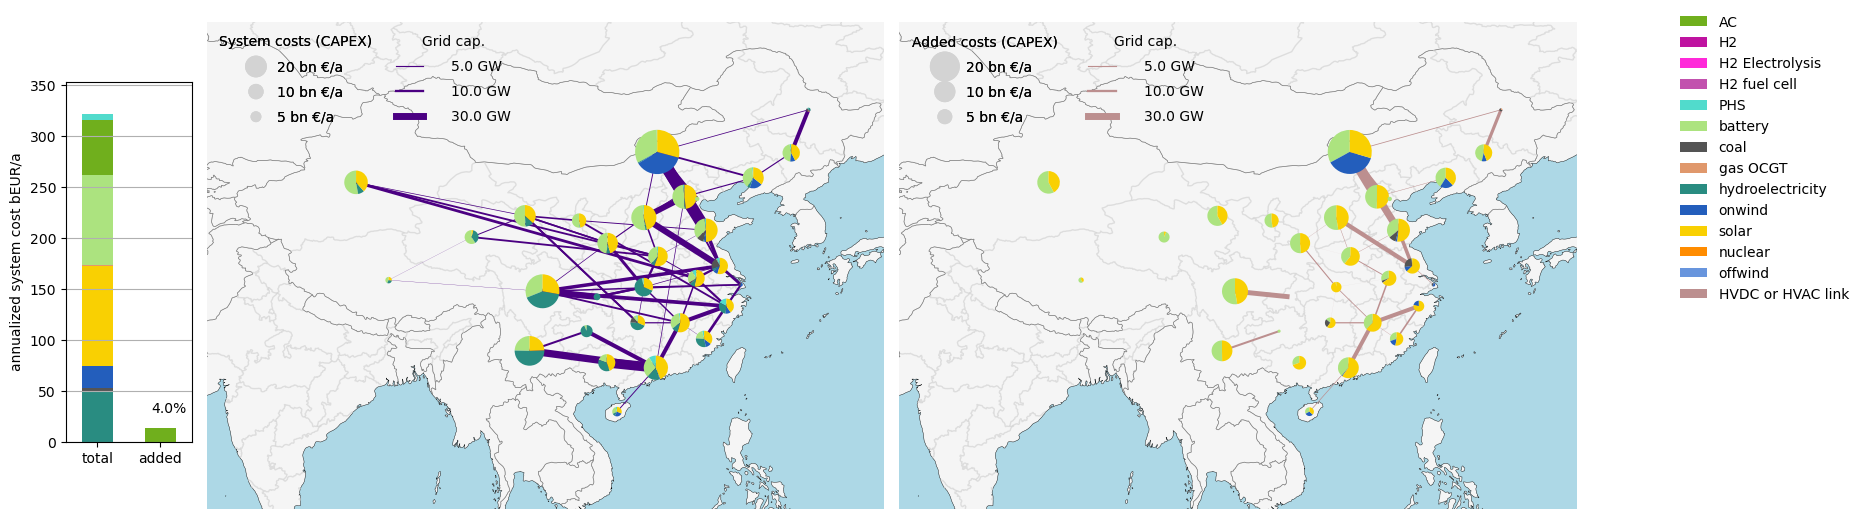

In [ ]:
with io.capture_output() as captured:
    ax = plot_cost_map(n, config["plotting"], cost_pannel=True, capex_only=True)

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:349: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


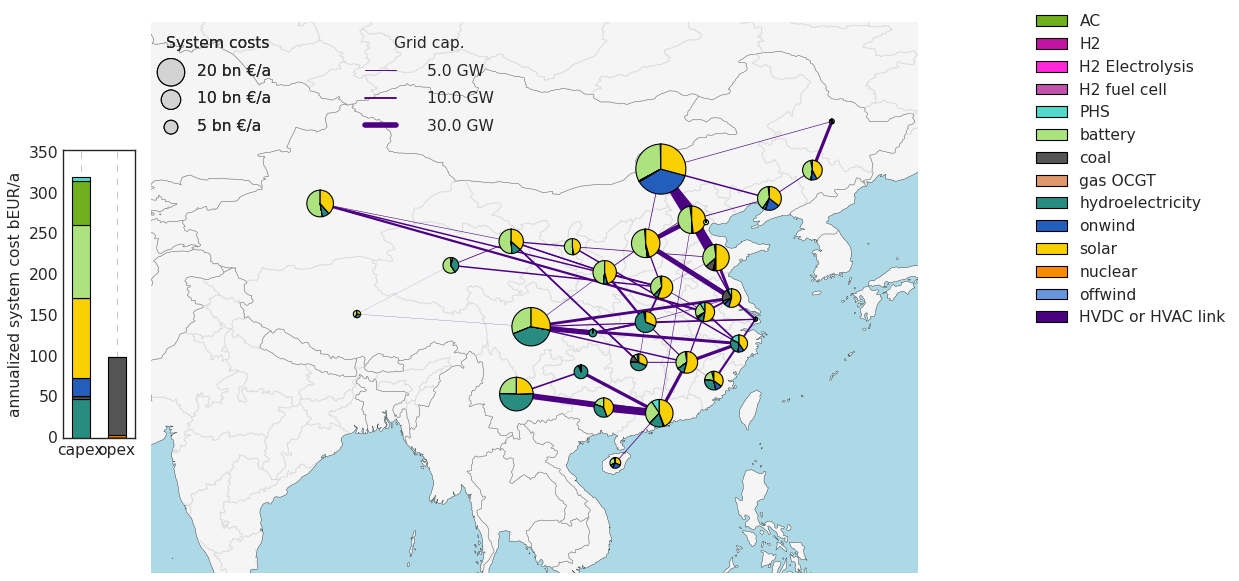

In [ ]:

# TODO fix layout
with io.capture_output() as captured:
    ax = plot_cost_map(n, config["plotting"], cost_pannel=True, plot_additions=False, capex_only=False)

## plot electricy generation map

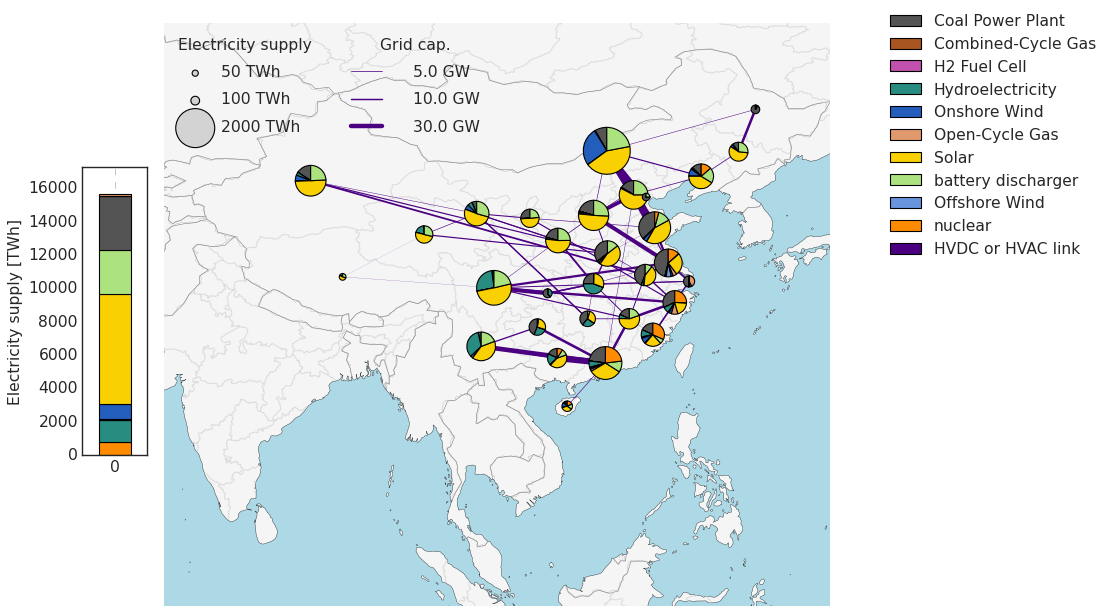

In [76]:
from IPython.utils import io

with io.capture_output() as captured:
    plot_energy_map(n,config["plotting"], carrier="AC", components = ["Generator", "Link"])


In [8]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style

if snakemake.config["heat_coupling"]:
    set_plot_style(
        style_config_file= os.path.abspath("../../config/plotting_styles/network_map.mplstyle"),
        #snakemake.config["plotting"]["network_style_config_file"],
        base_styles=["classic", "seaborn-v0_8-white"],
    )
    plot_energy_map(n,config["plotting"], carrier="heat", components = ["Generator", "Link"])

## Nodal prices

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


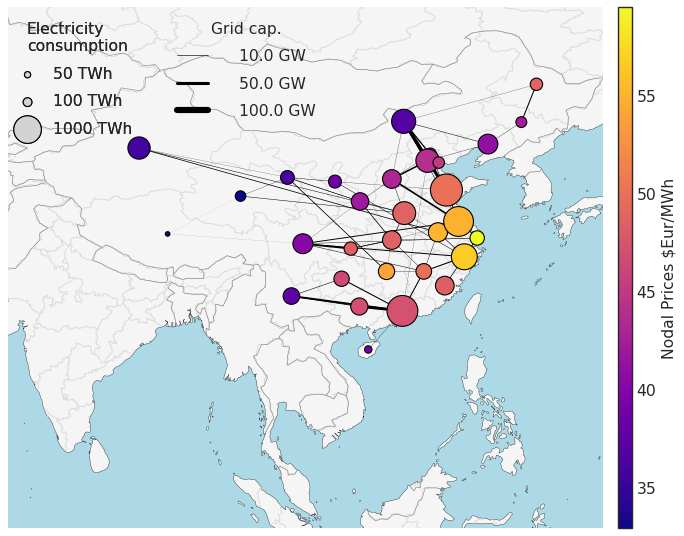

In [ ]:
from plot_network import plot_nodal_prices
with io.capture_output() as captured:
    plot_nodal_prices(n, config["plotting"], "AC")

## Interactive plot map

In [10]:
import numpy as np
# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: 'black' if 'ext' in x else 'pink')
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains('reversed')] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier=="stations" else "", axis=1)
buses["sizes"] = buses.apply(lambda x:10 if x.carrier == "AC" or x.carrier=="stations" else 0, axis=1)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(link_colors=colors, link_widths=widths, link_text = names.p_nom_opt.astype(str) + names.name, bus_text=buses.name, bus_sizes=buses.sizes, bus_colors=buses.colors)

/p/tmp/ivanra/anaconda/ipykernel_3020255/316105652.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""


### extendable lines

# CO2 emissions & Stores


In [13]:
n.global_constraints

Empty DataFrame
Columns: [type, investment_period, carrier_attribute, sense, constant, mu]
Index: []

<Axes: xlabel='snapshot'>

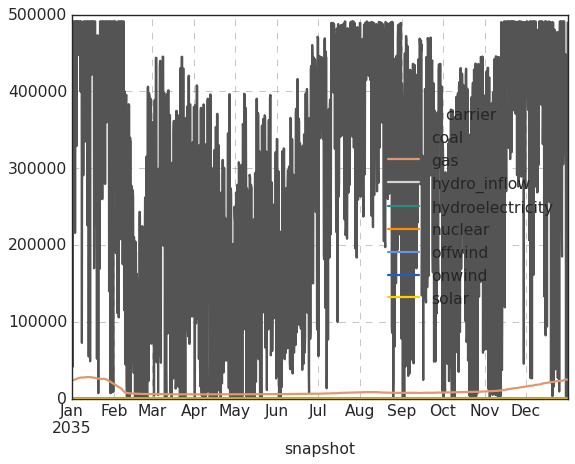

In [14]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
time_res_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum()
colors = time_res_emissions.T.columns.map(tech_colors).fillna("lightgrey")
time_res_emissions.T.plot(ax =ax, color =  colors, legend = True)

Text(0, 0.5, 'cum CO2 emissions [t]')

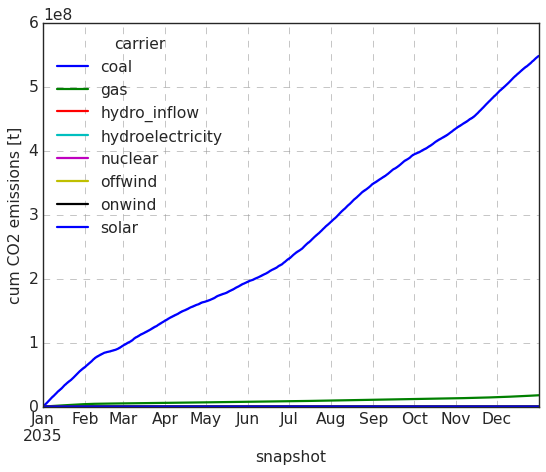

In [15]:
gen_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.cumsum()
fig, ax = plt.subplots()
gen_emissions.where(gen_emissions>=0).dropna(axis=1, how="all").plot(ax=ax)
ax.set_ylabel("cum CO2 emissions [t]")


Overnight model does not have CO2 capture or biomass stores, skipped


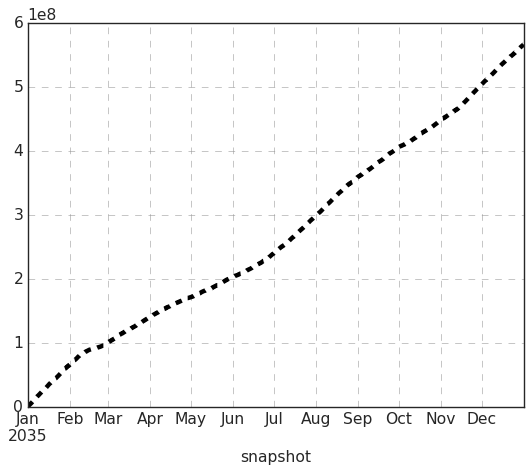

In [16]:
try:
    fig, ax = plt.subplots()
    # calc the t resolved CO2 emissions from generators
    ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().sum().T.cumsum().plot(ax =ax, label = "CO2 emissions (cum)", lw=4, c ="black", ls = "--")
    n.stores_t.e.T.groupby(n.stores.carrier).sum().loc[["CO2","H2", "CO2 capture", "gas", "biomass"]].T.plot(lw=4, cmap ="jet", ax =ax)
    ax.legend()
    ax.semilogy()
    ax.set_ylim(1e3,1e10)
    ax.set_ylabel("carrier stock")
except KeyError:
    print("Overnight model does not have CO2 capture or biomass stores, skipped")

<Axes: xlabel='snapshot'>

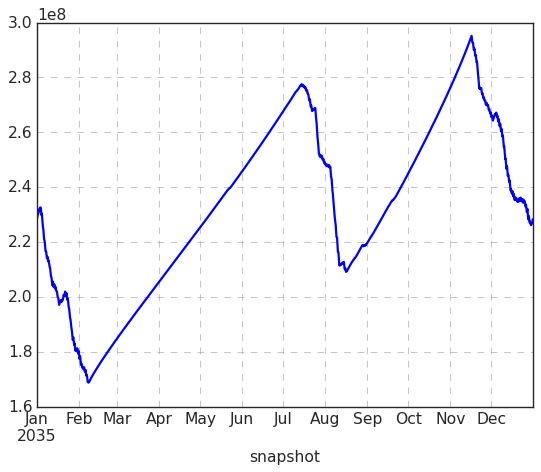

In [17]:

gas_stores = n.stores[n.stores.carrier.str.contains("gas")]
gas_stores_t = n.stores_t.e[n.stores_t.e.columns.intersection(gas_stores.index)]
gas_stores_t.sum(axis=1).plot()

## CO2 capture
! beware the store is the difference :)

In [18]:
try:
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    diff = stores.iloc[:, -1] -stores.iloc[:, 0]
    co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
    co2_cap
except KeyError:
    print("Overnight model does not have CO2 capture or biomass stores, skipped")


Overnight model does not have CO2 capture or biomass stores, skipped


<Axes: xlabel='snapshot'>

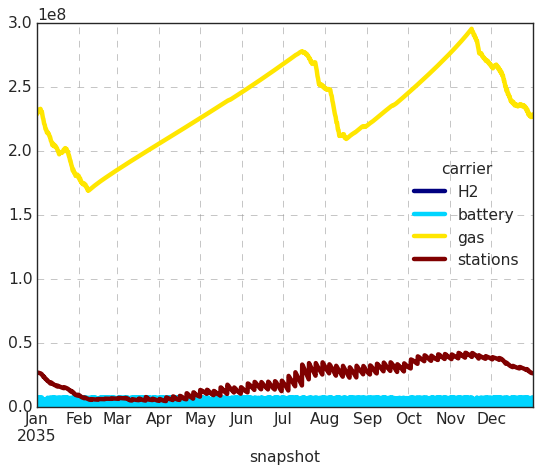

In [19]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot(lw=4, cmap ="jet")

# Time series

## Weekly energy balances

In [20]:
from plot_time_series import plot_energy_balance

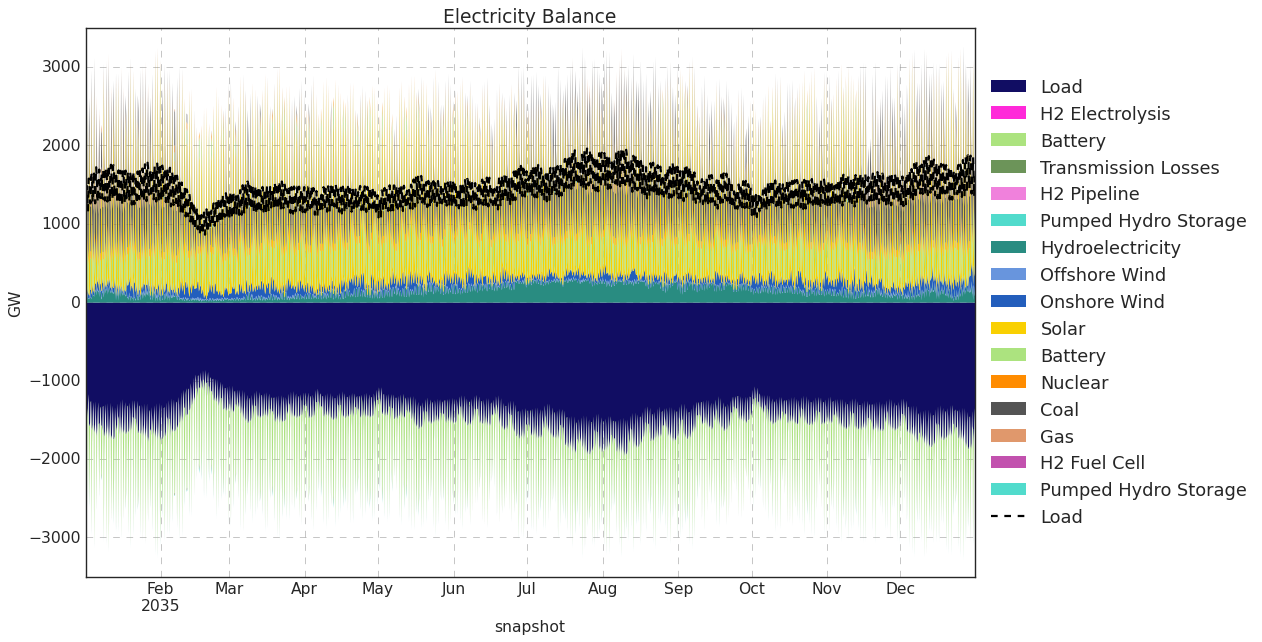

In [77]:
with io.capture_output() as captured:
    ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-01-01 01:00", end_date=f"{PLANNING_YEAR}-12-31 12:00:00")
    ax.grid(axis='y')
    ax.set_title("Electricity Balance")

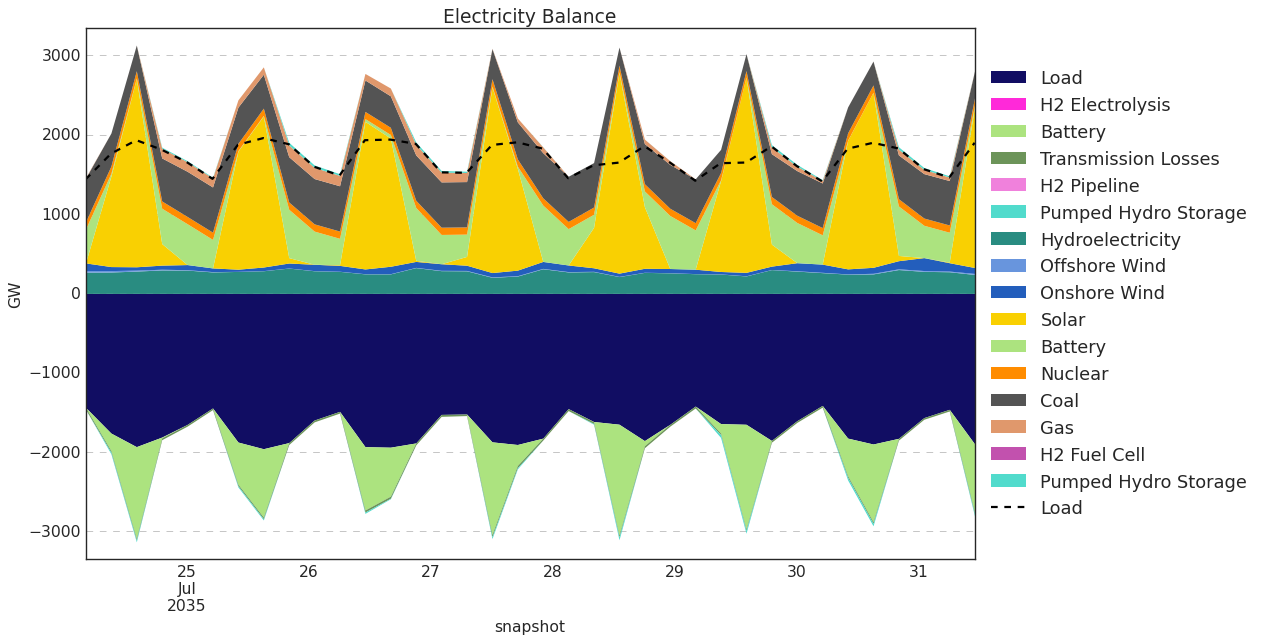

In [78]:
with io.capture_output() as captured:
    ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-07-24 00:00", end_date=f"{PLANNING_YEAR}-07-31 12:00:00")
    ax.grid(axis='y')
    ax.set_title("Electricity Balance")

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Electricity Balance')

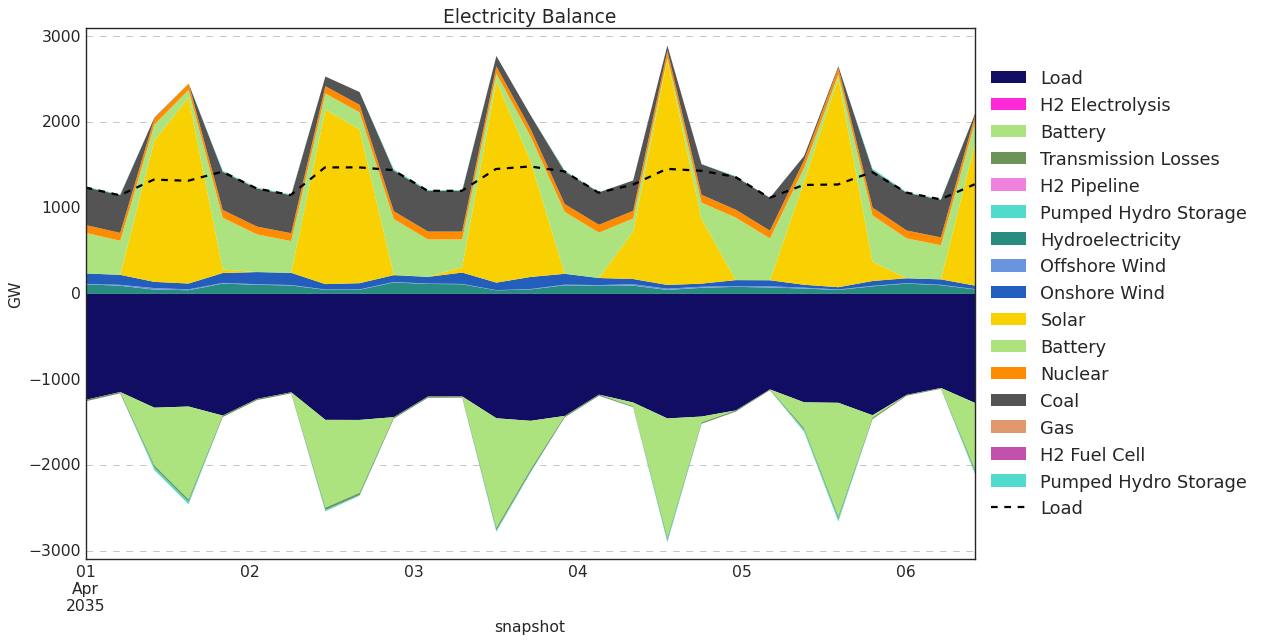

In [ ]:
with io.capture_output() as captured:
    ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-03-31 21:00", end_date=f"{PLANNING_YEAR}-04-06 12:00:00")
    ax.grid(axis='y')
    ax.set_title("Electricity Balance")

## price series

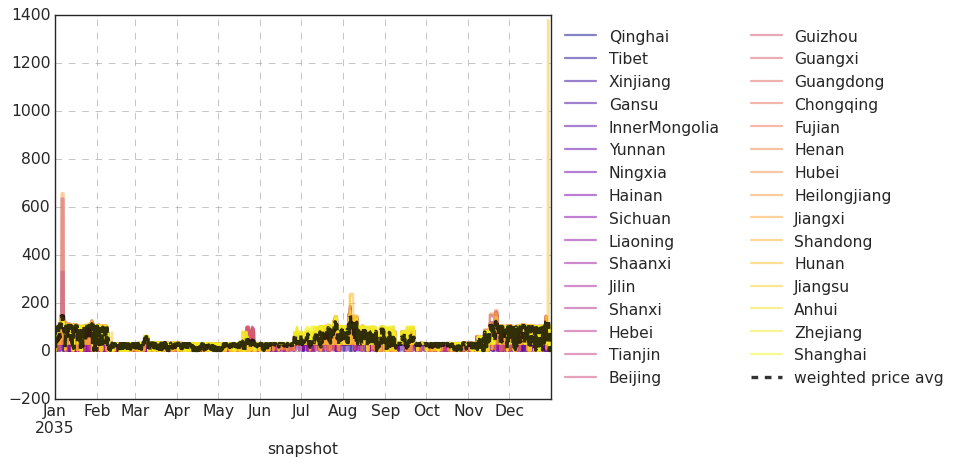

In [79]:
from constants import PROV_NAMES 
marginal_price_series = n.buses_t["marginal_price"][PROV_NAMES]
prov_max_price_series = marginal_price_series.T.max()
prov_min_price_series = marginal_price_series.T.min()
spread = marginal_price_series.T.max()-marginal_price_series.T.min()
load_ac = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False, groupby="location", comps = "Load")

regional_weighed_price = marginal_price_series.T.mul(load_ac).T.sum()/load_ac.T.sum()
order =regional_weighed_price.sort_values().index

weighed_prices = (marginal_price_series.T.mul(load_ac)/load_ac.sum()).sum()
ax = marginal_price_series[order].plot(alpha=0.5, lw=2, legend=False, cmap="plasma")
weighed_prices.plot(ax = ax, lw=3, c="black", label = "weighted price avg", alpha =0.8, ls = "--")
ax.legend(  loc='upper left', bbox_to_anchor=(1, 1), ncols=2);

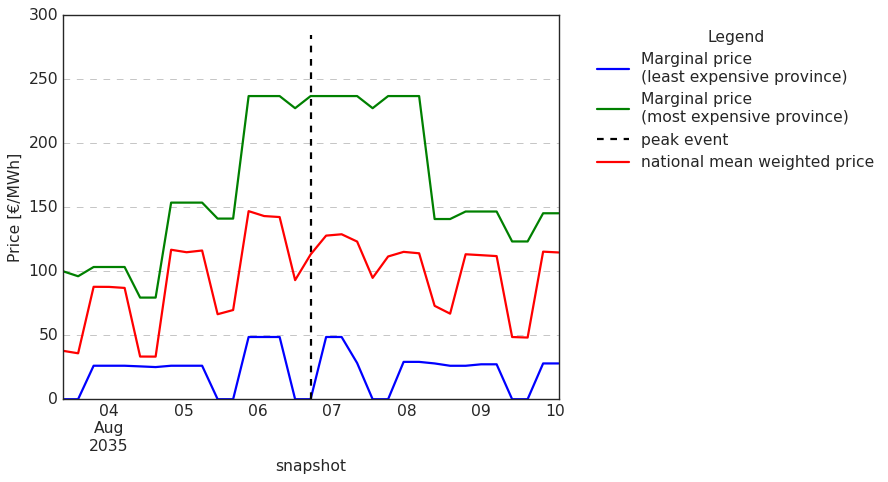

In [80]:
from _plot_utilities import find_weeks_of_interest
from constants import PROV_NAMES

winter_week, summer_week = find_weeks_of_interest(n, f"{PLANNING_YEAR}-04-01", f"{PLANNING_YEAR}-10-06")
marginal_price_series = n.buses_t["marginal_price"][PROV_NAMES]
prov_max_price_series = marginal_price_series.T.max()
prov_min_price_series = marginal_price_series.T.min()
spread = marginal_price_series.T.max()-marginal_price_series.T.min()
load_ac = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False, groupby="location", comps = "Load")
weighed_prices = (marginal_price_series.T.mul(load_ac)/load_ac.sum()).sum()


ax = prov_min_price_series.loc[summer_week].plot(label = "Marginal price\n(least expensive province)")
prov_max_price_series.loc[summer_week].plot(label = "Marginal price\n(most expensive province)", ax =ax)
# spread.loc[summer_week].plot(label = "Price spread", ax =ax, ls= "--")
ax.set_ylabel("Price [€/MWh]")
# ax.vlines(winter_week[len(winter_week)//2], 0,prov_max_price_series.max()*1.2, color="black", ls = "--", label="peak event")
ax.vlines(summer_week[len(summer_week)//2], 0,prov_max_price_series.loc[summer_week].max()*1.2, color="black", ls ="--", label="peak event")

weighed_prices.loc[summer_week].plot(ax=ax, label ="national mean weighted price")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend");

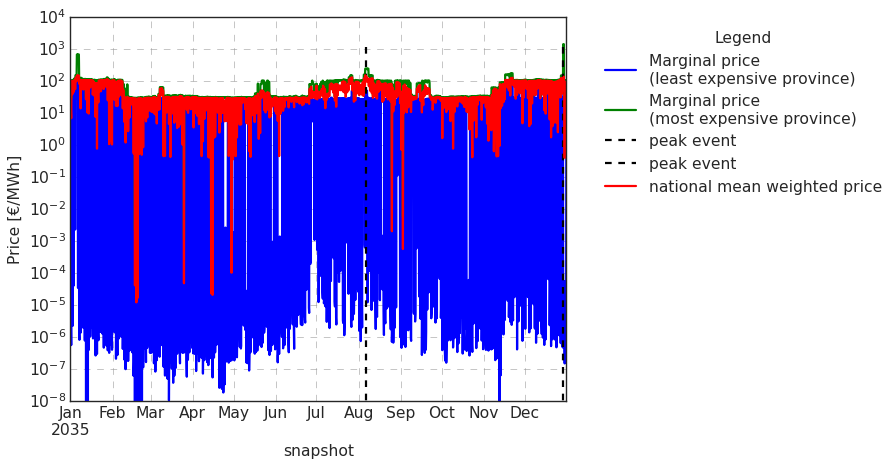

In [81]:

ax = prov_min_price_series.plot(label = "Marginal price\n(least expensive province)", logy=True)
ax = prov_max_price_series.plot(label = "Marginal price\n(most expensive province)", logy=True)
ax.set_ylabel("Price [€/MWh]")
ax.vlines(winter_week[len(winter_week)//2], 0,prov_max_price_series.max()*1.2, color="black", ls = "--", label="peak event")
ax.vlines(summer_week[len(summer_week)//2], 0,prov_max_price_series.max()*1.2, color="black", ls ="--", label="peak event")

weighed_prices.plot(ax=ax, label ="national mean weighted price", logy=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend");

## Prices - balance overlay

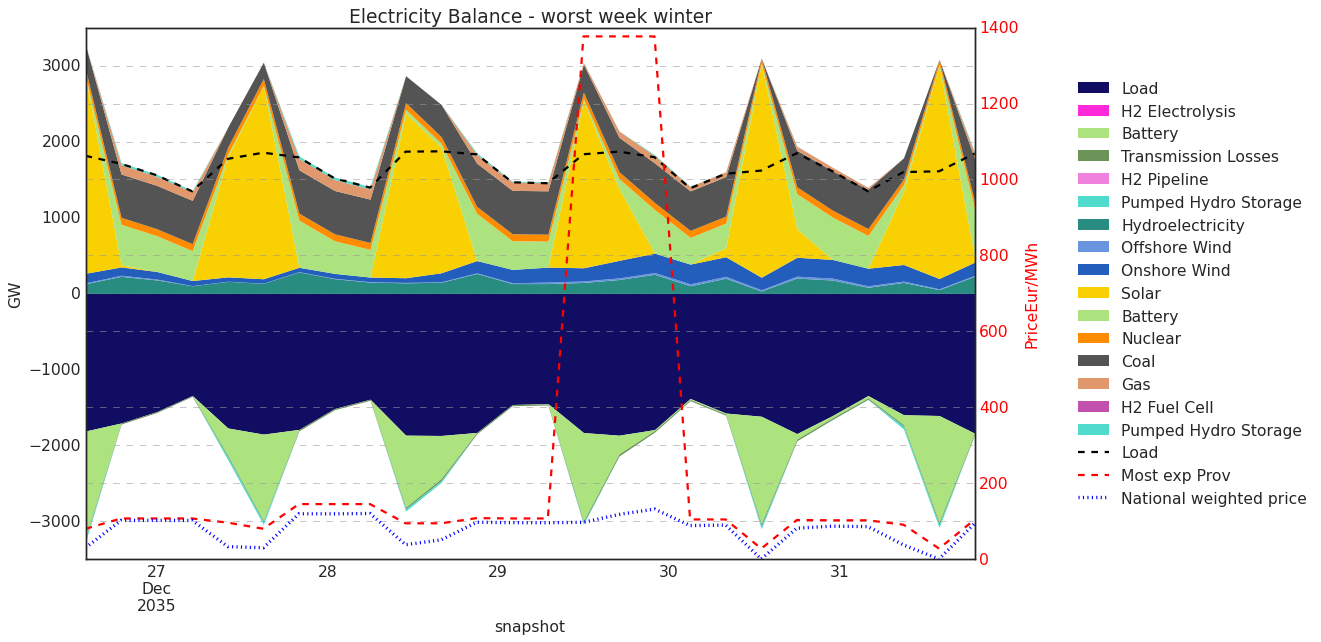

In [82]:
with io.capture_output() as captured:
    ax = plot_energy_balance(n, config["plotting"], start_date=str(winter_week[0]), end_date=str(winter_week[-1]))
    ax.grid(axis='y')
    ax.set_title("Electricity Balance - worst week winter")
    ax2 = ax.twinx()
    prov_max_price_series.loc[winter_week].plot(ax=ax2, color="red", lw=2, ls = "--", label= "Most exp Prov")
    weighed_prices.loc[winter_week].plot(ax=ax2, color = "blue", lw=3, ls = ":",label = "National weighted price")
    fig = ax.get_figure()
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis='y', labelcolor='red')
    # Move the existing legend to the right
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))


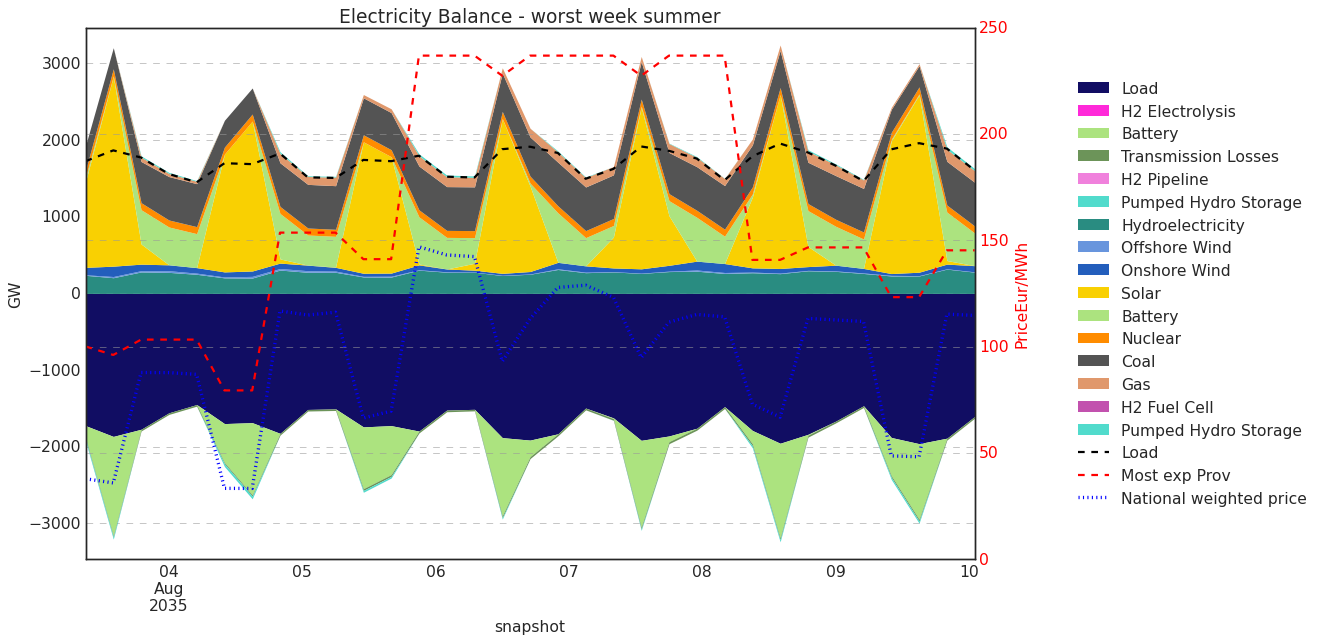

In [83]:
with io.capture_output() as captured:
    ax = plot_energy_balance(n, config["plotting"], start_date=str(summer_week[0]), end_date=str(summer_week[-1]))
    ax.grid(axis='y')
    ax.set_title("Electricity Balance - worst week summer")
    ax2 = ax.twinx()
    prov_max_price_series.loc[summer_week].plot(ax=ax2, color="red", lw=2, ls = "--", label= "Most exp Prov")
    weighed_prices.loc[summer_week].plot(ax=ax2, color = "blue", lw=3, ls = ":",label = "National weighted price")
    fig = ax.get_figure()
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis='y', labelcolor='red')
    # Move the existing legend to the right
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))


In [29]:
if snakemake.config["heat_coupling"]:
    ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-03-31 21:00", end_date=f"{PLANNING_YEAR}-09-06 12:00:00", bus_carrier="heat")
    ax.set_title("Heat balance")
    ax2 = ax.twinx()
    prov_max_price_series.loc[f"{PLANNING_YEAR}-03-31 21:00":f"{PLANNING_YEAR}-09-06 12:00:00"].plot(ax=ax2, color="red", lw=2, ls = "--", label= "Most exp Prov")
    weighed_prices.loc[f"{PLANNING_YEAR}-03-31 21:00":f"{PLANNING_YEAR}-09-06 12:00:00"].plot(ax=ax2, color = "blue", lw=3, ls = ":",label = "National weighted price")
    prov_min_price_series.loc[f"{PLANNING_YEAR}-03-31 21:00":f"{PLANNING_YEAR}-09-06 12:00:00"].plot(ax=ax2, color="green", lw=2, ls = "--", label= "Least exp Prov")

    fig = ax.get_figure()
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim([0, prov_max_price_series.loc[f"{PLANNING_YEAR}-03-31 21:00":f"{PLANNING_YEAR}-09-06 12:00:00"].max()*3])
    # Move the existing legend to the right
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))


In [30]:
if snakemake.config["heat_coupling"]:
    ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-01-01 00:00", end_date=f"{PLANNING_YEAR}-12-31 23:00:00", bus_carrier="heat")
    ax.set_title("Heat balance")

In [ ]:
from plot_time_series import plot_residual_load_duration_curve, plot_load_duration_curve, plot_regional_load_durations


# LOAD DURATION CURVES

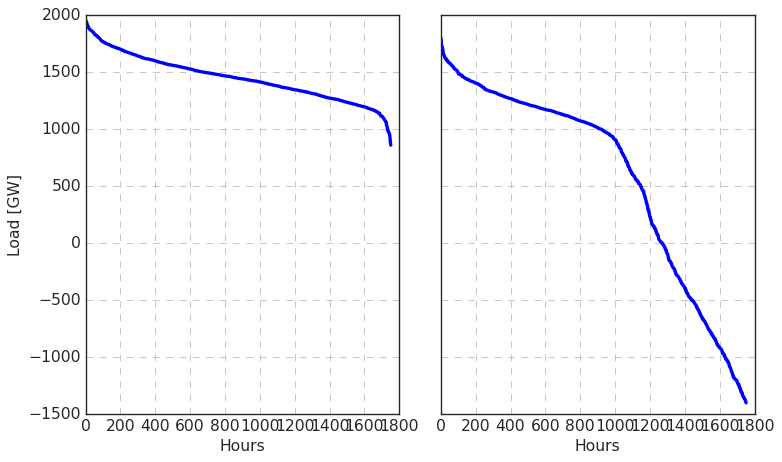

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_load_duration_curve(n, carrier="AC", ax = ax[0])
plot_residual_load_duration_curve(n, ax = ax[1])
fig.tight_layout()

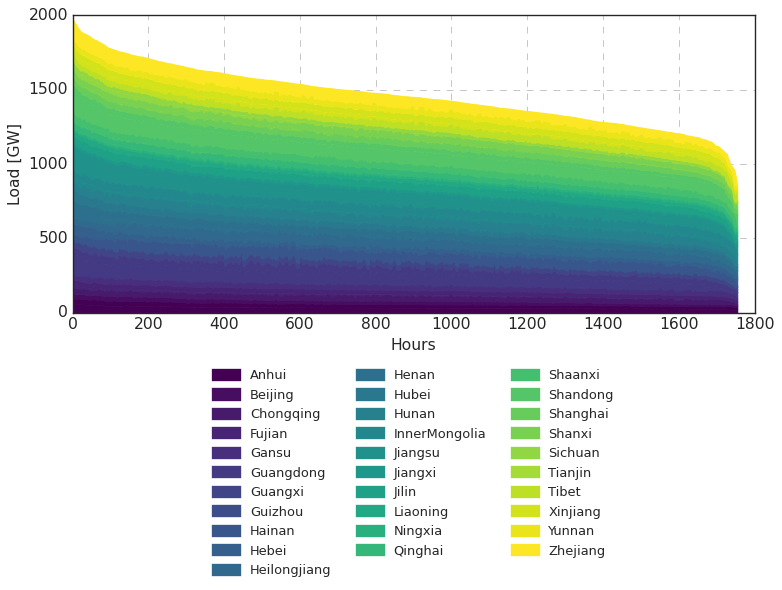

In [86]:
with io.capture_output() as captured:

    plot_regional_load_durations(n, carrier="AC", cmap = "viridis")


Text(0, 0.5, 'EnergyDemand / GW')

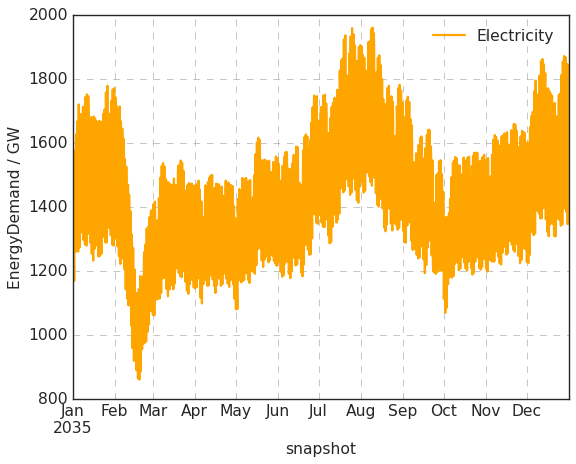

In [33]:
fix, ax = plt.subplots()
ds_AC = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False).loc[("Load", "-")]/1e3
ds_AC.plot(ax=ax, label="Electricity",  c="orange")
if snakemake.config["heat_coupling"]:
    ds_heat = n.statistics.withdrawal(bus_carrier="heat", aggregate_time=False).loc[("Load", "-")]/1e3
    ds_heat.plot(ax=ax, label="Heat", c = "blue")  
ax.legend()
ax.set_ylabel("EnergyDemand / GW")

## Power flows map

In [90]:
from _pypsa_helpers import get_location_and_carrier
transmission = n.statistics.transmission(
        bus_carrier="AC",
        groupby=get_location_and_carrier,
        aggregate_time=False,
    )/1e6 # # convert to TW 
transm_tot = transmission.T.sum().reset_index()
transm_tot = transm_tot.set_index("location").rename(columns={0:"HV transmission"}).sort_values(by="HV transmission")
regi_transmission =  transmission.groupby("location").sum().loc[transm_tot.index[::-1]]

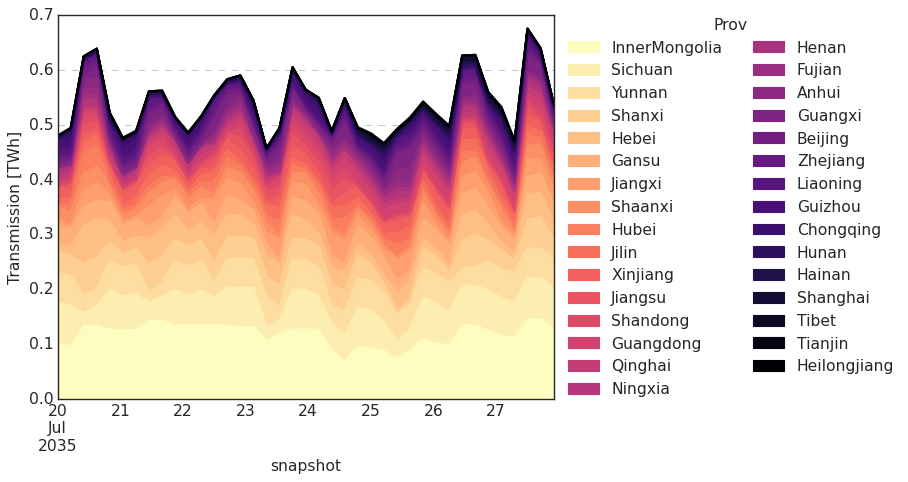

In [92]:
ax = (
    regi_transmission.T.loc[f"{PLANNING_YEAR}-07-20":f"{PLANNING_YEAR}-07-27"]
    .plot.area(stacked=True, cmap="magma_r")
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Prov", ncols=2)
ax.set_ylabel("Transmission [TWh]");

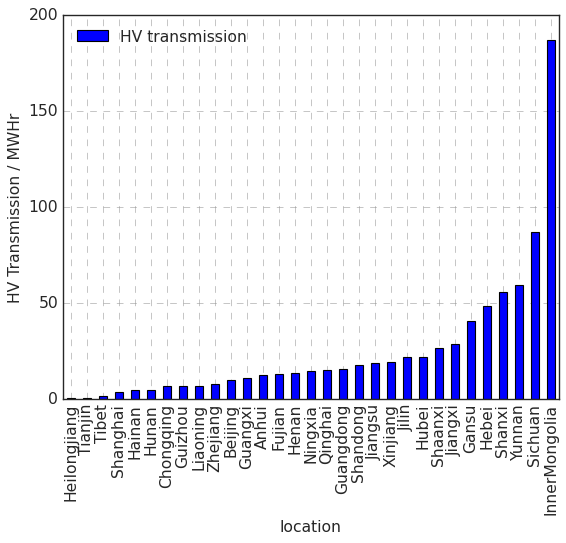

In [93]:
ax = transm_tot.plot.bar(y="HV transmission")
ax.set_ylabel("HV Transmission / MWHr");

### Plot cap factors time series

In [37]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

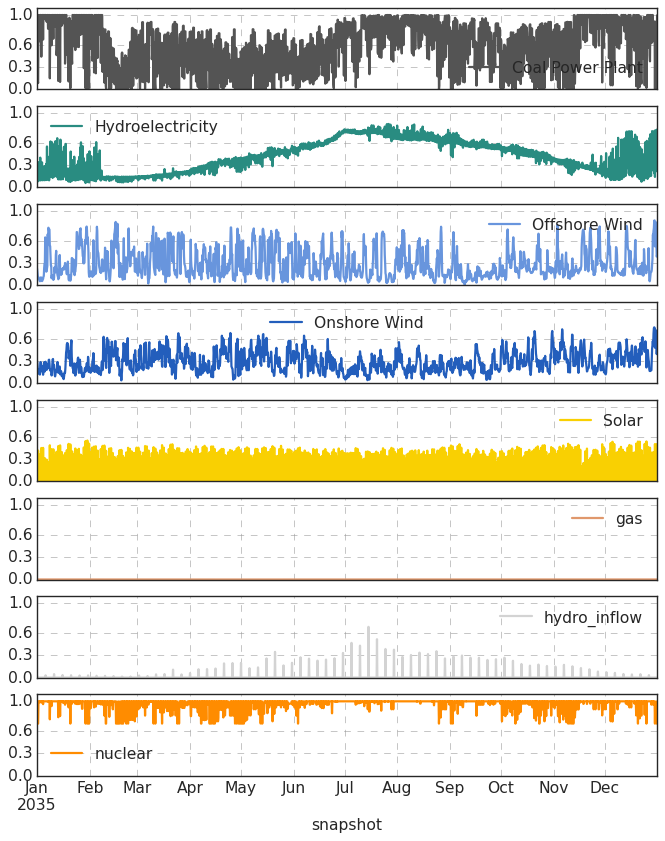

In [38]:
colors_lowered = {k.lower().rstrip():v for k,v in config["plotting"]["tech_colors"].items()}
cap_colors = {k: colors_lowered.get(k.lower().rstrip(), "lightgrey") for k in [c for c in capacity_factors.columns]}
axes = capacity_factors.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12), color= cap_colors)
for ax in axes:
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.3, 0.6,1])

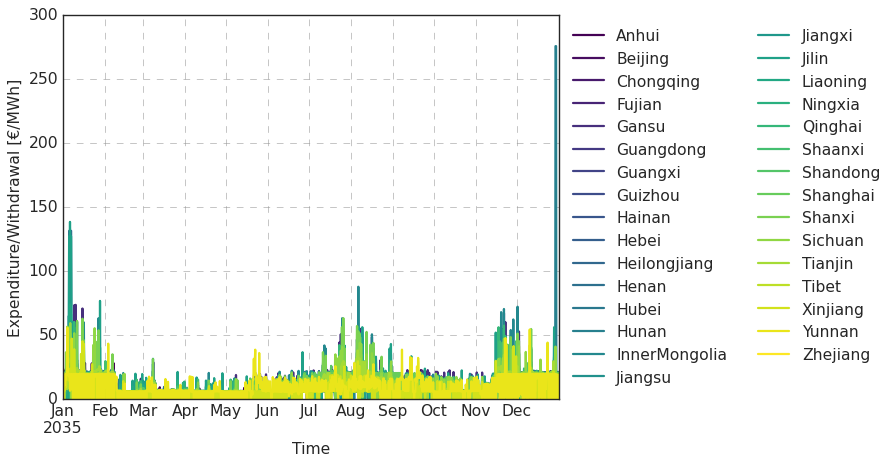

In [41]:
region_rev = n.statistics.revenue(groupby = ["location", "carrier"], bus_carrier="AC", aggregate_time=False).fillna(0)
rev_regional = region_rev[(region_rev<0).all(axis=1)].groupby("location").sum().T
prod_reg = n.statistics.energy_balance(groupby = ["location", "carrier"], bus_carrier="AC", aggregate_time=False)*weighting
consum_regional = prod_reg.query("component=='Load'").groupby("location").sum().T
balance = prod_reg.groupby("location").sum().T
supp_regional = prod_reg.query("component!='Load'").groupby("location").sum().T
ax = (rev_regional/consum_regional).plot(cmap="viridis")
ax.set_ylabel("Expenditure/Withdrawal [€/MWh]")
ax.set_xlabel("Time")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=2)


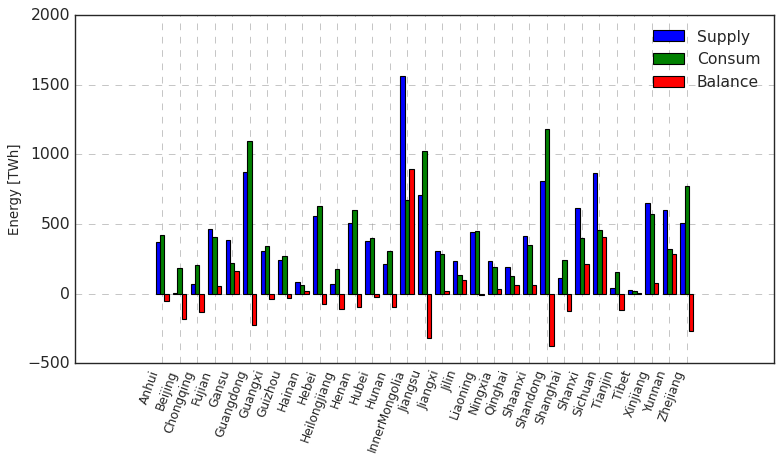

In [42]:
import numpy as np

import matplotlib.pyplot as plt

data = pd.concat([supp_regional.sum(), -1*consum_regional.sum(), balance.sum()], axis=1)
data.columns = ["Supply", "Consum", "Balance"]
data = data.query("index != ''") # no location assigned
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
x = np.arange(len(data.index))
data = data/1e6
ax.bar(x - bar_width, data["Supply"], width=bar_width, label="Supply")
ax.bar(x, data["Consum"], width=bar_width, label="Consum")
ax.bar(x + bar_width, data["Balance"], width=bar_width, label="Balance")

ax.set_xticks(x)
ax.set_xticklabels(data.index, rotation =70, ha ='right', fontsize=11)
ax.legend()
ax.set_ylabel("Energy [TWh]", fontsize=12)
fig.tight_layout()
plt.show()

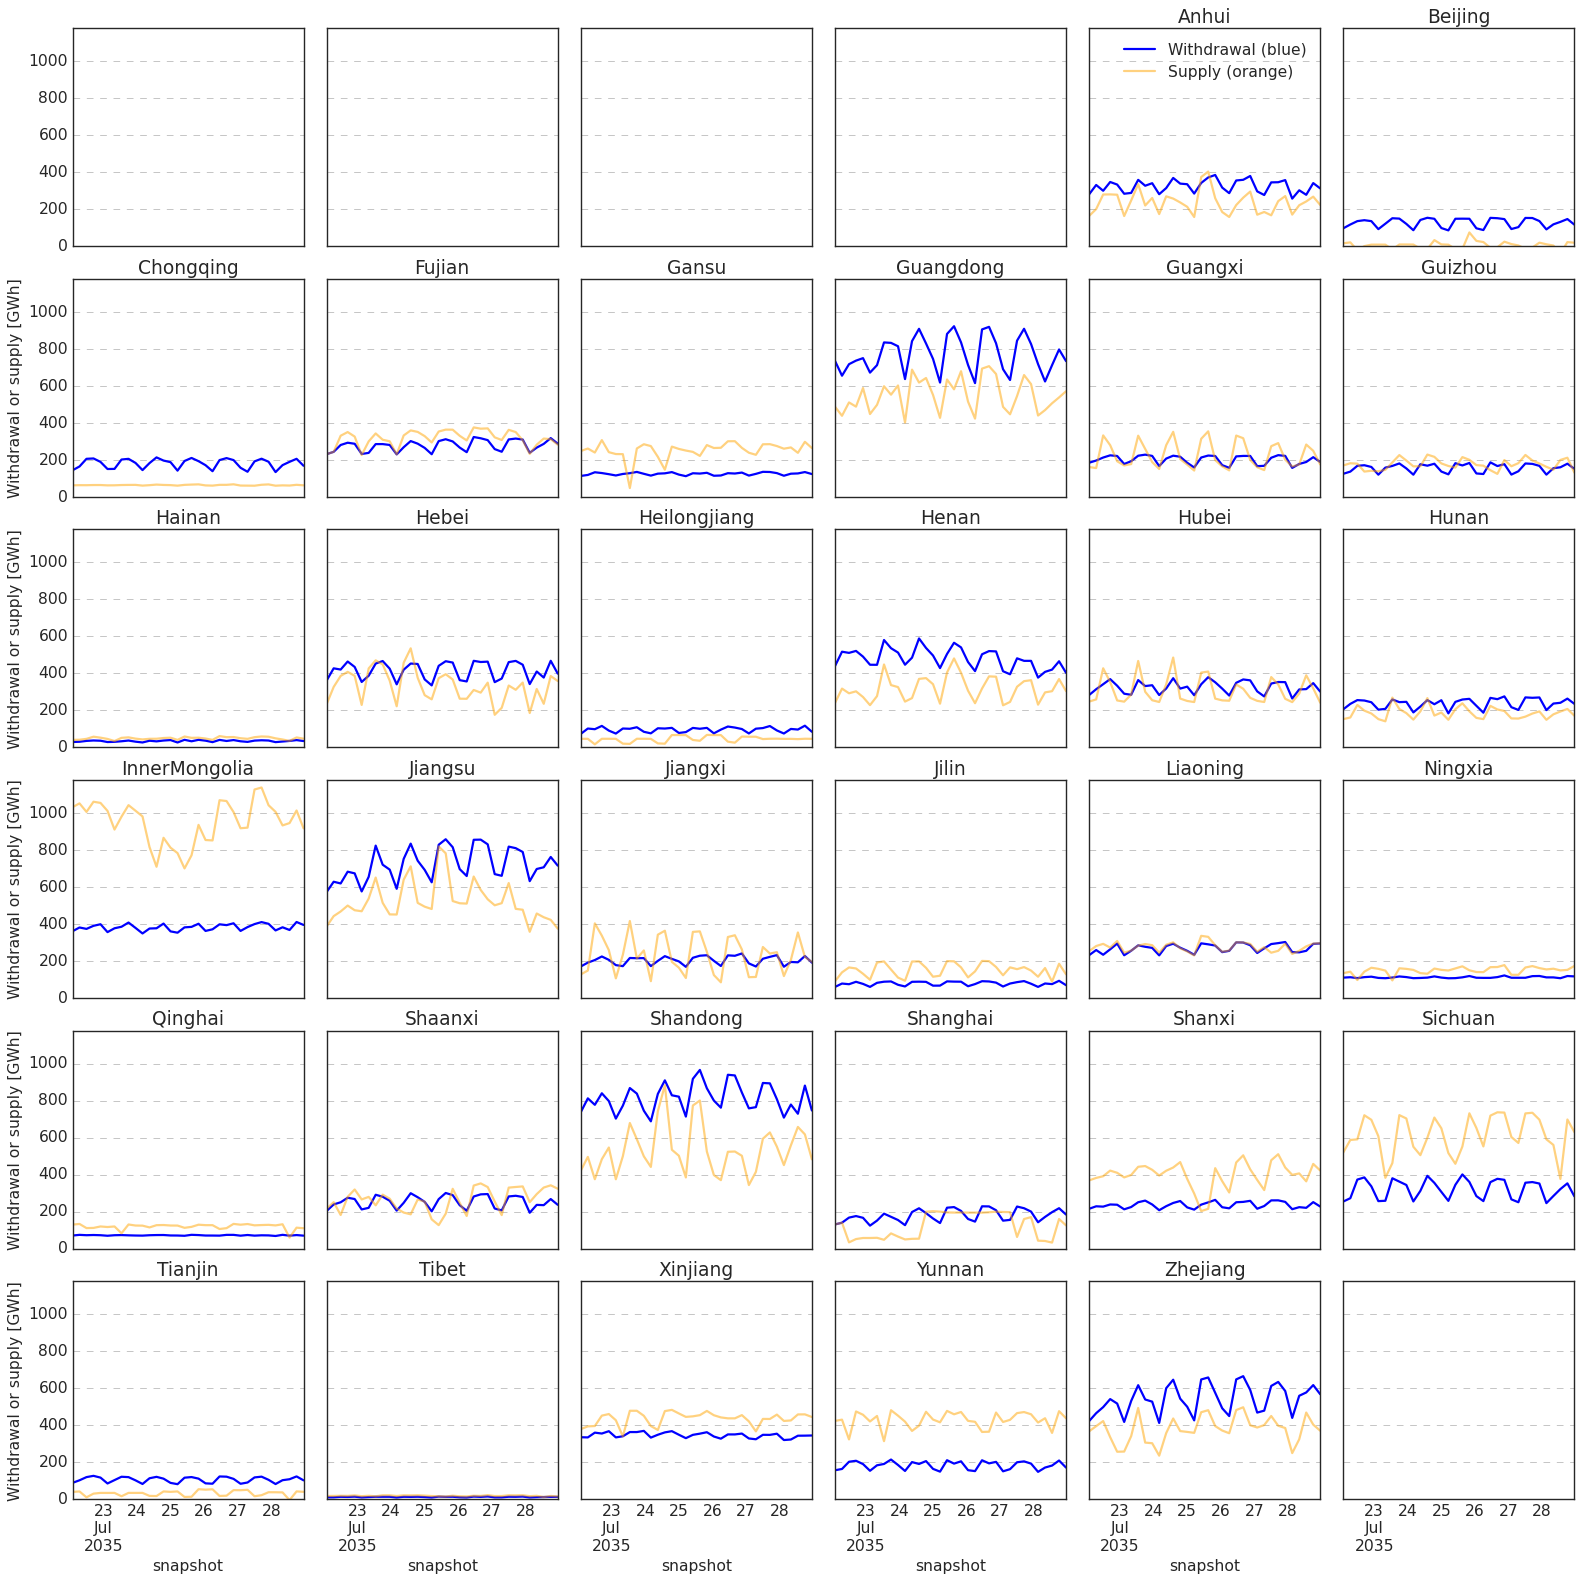

In [43]:
max_val = max(supp_regional.max().max(), -1*consum_regional.max().max())

fig, axes = plt.subplots(6,6, sharex=True, sharey=True, figsize=(20,20))
norm_price =  n.buses_t["marginal_price"][PROV_NAMES].loc[f"{PLANNING_YEAR}-07-22":f"{PLANNING_YEAR}-07-28"]
norm_price/= norm_price.max()
norm_price*=(consum_regional*-1e-6).loc[f"{PLANNING_YEAR}-07-22":f"{PLANNING_YEAR}-07-28"].max().max()*0.8
consum_regional = consum_regional[PROV_NAMES]
for i,c in enumerate(consum_regional.columns):
    k, l = (i+4)//6, (i+4)%6
    (consum_regional[c]*-1e-3).loc[f"{PLANNING_YEAR}-07-22":f"{PLANNING_YEAR}-07-28"].plot(ax=axes[k,l])
    (supp_regional[c]*1e-3).loc[f"{PLANNING_YEAR}-07-22":f"{PLANNING_YEAR}-07-28"].plot(ax=axes[k,l], color = "orange", alpha = 0.5)
    axes[k,l].set_title(c)
    axes[k,l].set_ylim(0, max_val*1e-3)

    if l ==0:
        axes[k,l].set_ylabel("Withdrawal or supply [GWh]")
    if k==0:
        axes[k,l].set_xlabel("Time")
axes[0, 4].legend(["Withdrawal (blue)", "Supply (orange)"])
fig.tight_layout()
fig.subplots_adjust(hspace=0.15, wspace=0.1)




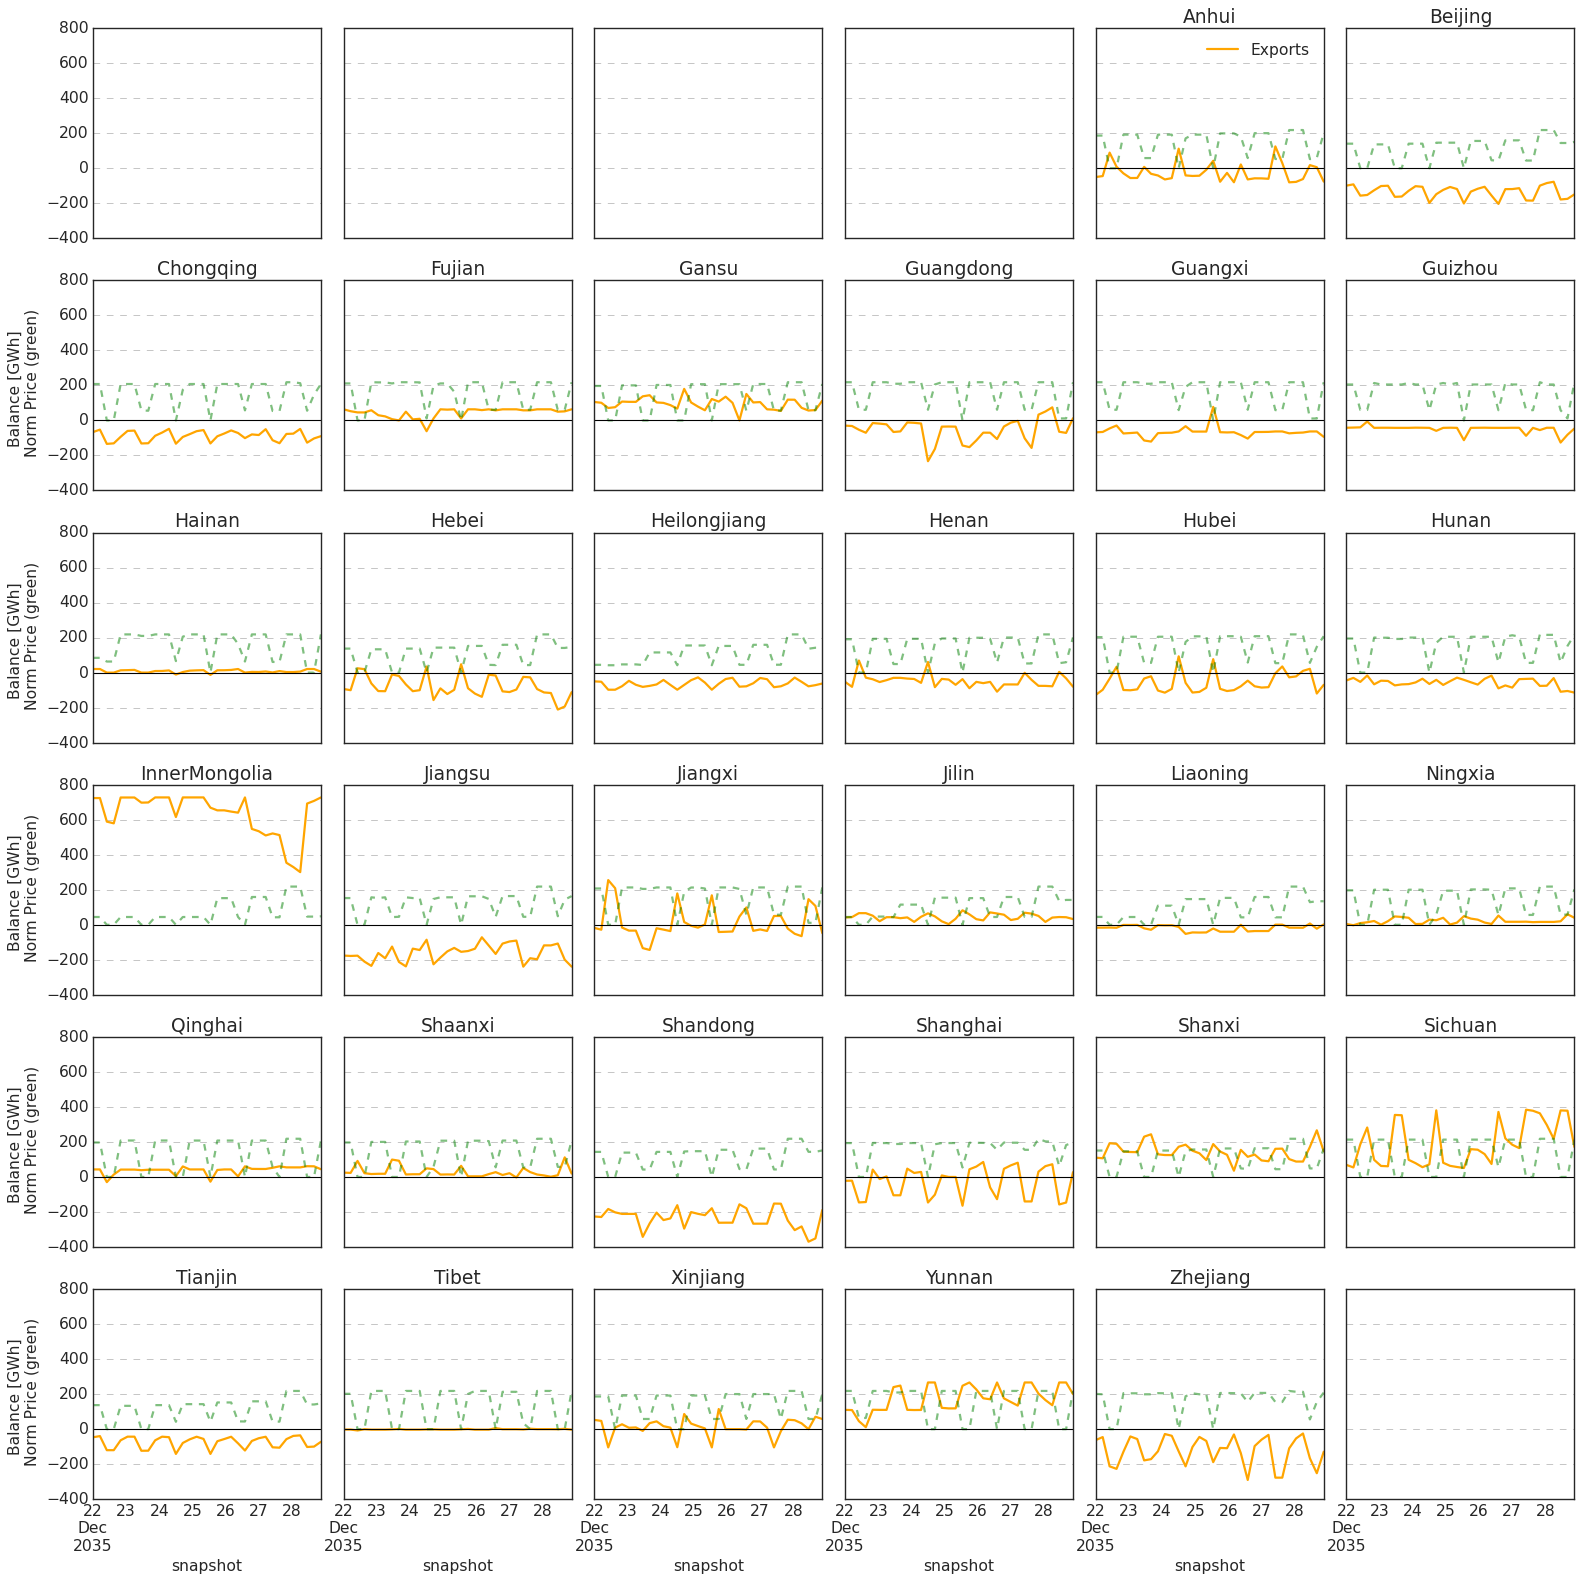

In [44]:
exports_regional =balance
max_val = balance.max().max()
fig, axes = plt.subplots(6,6, sharex=True, sharey=True, figsize=(20,20))
norm_price =  n.buses_t["marginal_price"][PROV_NAMES].loc[f"{PLANNING_YEAR}-12-22":f"{PLANNING_YEAR}-12-28"]
norm_price/= norm_price.max()
norm_price*= max_val*0.3e-3
for i,c in enumerate(consum_regional.columns):
    k, l = (i+4)//6, (i+4)%6
    exports = (exports_regional[c]*1e-3).loc[f"{PLANNING_YEAR}-12-22":f"{PLANNING_YEAR}-12-28"]
    exports.plot(ax=axes[k,l], color = "orange", alpha = 1)
    norm_price[c].plot(ax=axes[k,l], color = "green", alpha = 0.5, legend = False, ls ="--")

    axes[k,l].set_title(c)
    # axes[k,l].set_ylim( exports.min(), exports.max())
    axes[k,l].axhline(0, color="black", lw=1)
    if l ==0:
        axes[k,l].set_ylabel("Balance [GWh] \n Norm Price (green)")
    if k==0:
        axes[k,l].set_xlabel("Time")
axes[0, 4].legend(["Exports"])
fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.1)

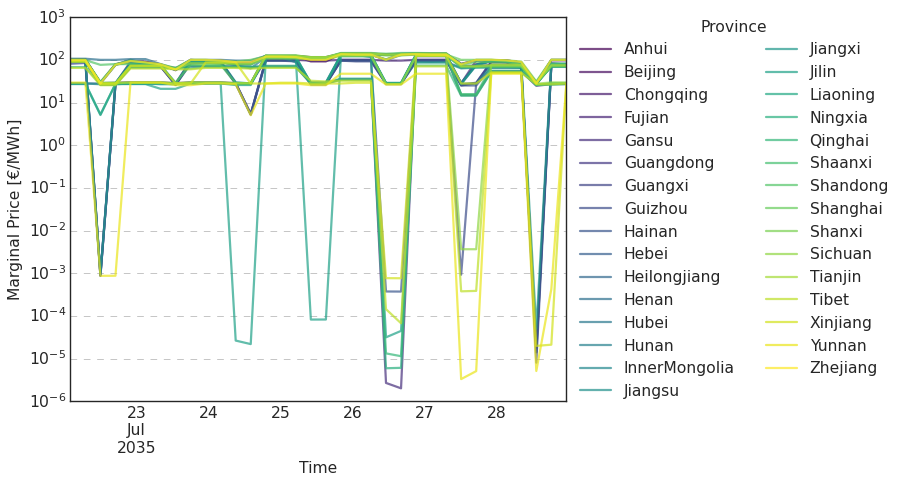

In [45]:
from constants import PROV_NAMES 
ax = n.buses_t["marginal_price"][PROV_NAMES].loc[f"{PLANNING_YEAR}-07-22":f"{PLANNING_YEAR}-07-28"].plot(cmap="viridis",alpha =0.7, logy=True)
ax.set_ylabel("Marginal Price [€/MWh]")
ax.set_xlabel("Time")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Province", ncol=2)

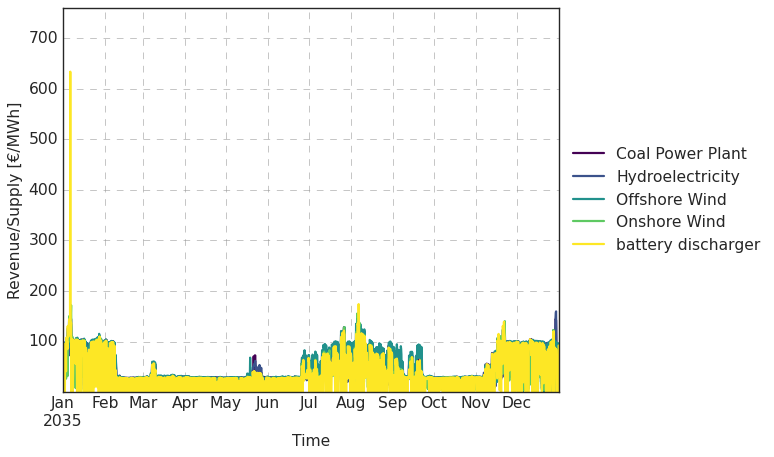

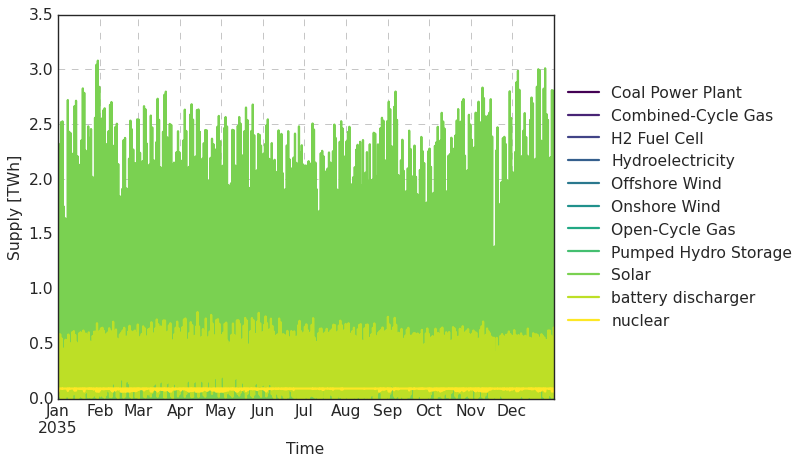

In [46]:
rev_and_exp = n.statistics.revenue(bus_carrier="AC", aggregate_time=False).fillna(0).groupby(level=1).sum().T
prod = n.statistics.energy_balance(bus_carrier="AC", aggregate_time=False).fillna(0)
prod = prod[~(prod<=0).all(axis=1)]
prod=prod.clip(lower=1e-5).groupby(level=1).sum().T
hourly_price = rev_and_exp.clip(lower=0)/prod
hourly_price = hourly_price.loc[:,(hourly_price>0).all(axis=0)]
ax = hourly_price.plot(logy=False, cmap = "viridis")
ax.set_ylim([1, hourly_price.max().max()*1.2])
ax.set_ylabel("Revenue/Supply [€/MWh]")
ax.set_xlabel("Time")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2 = (prod/1e6).plot(cmap="viridis", logy=False)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Carrier", ncol=2)
ax2.set_ylabel("Supply [TWh]")
ax2.set_xlabel("Time")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

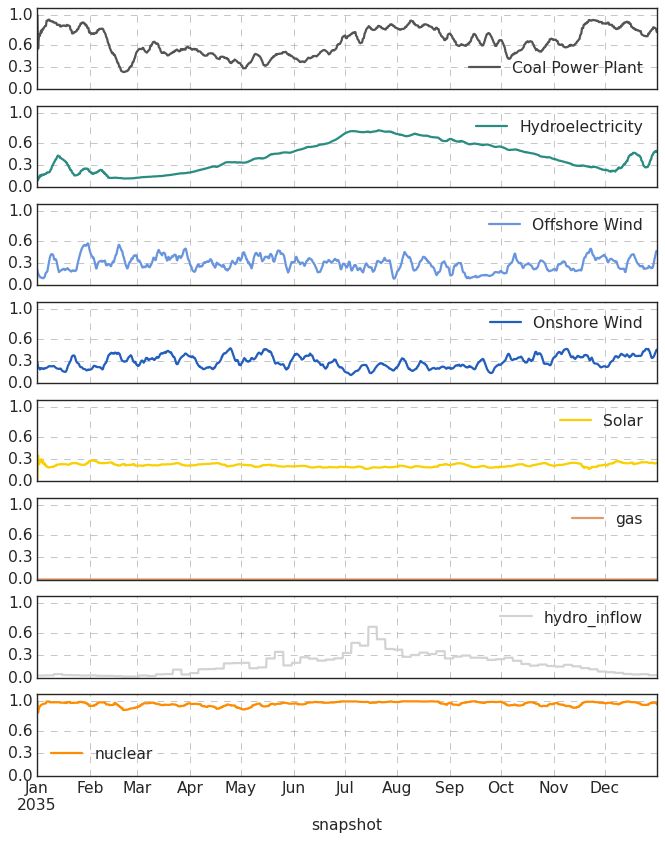

In [47]:
colors_lowered = {k.lower().rstrip():v for k,v in config["plotting"]["tech_colors"].items()}
cap_colors = {k: colors_lowered.get(k.lower().rstrip(), "lightgrey") for k in [c for c in capacity_factors.columns]}

# Apply rolling moving average filter
capacity_factors_smoothed = capacity_factors.rolling(window=24, min_periods=1).mean()

axes = capacity_factors_smoothed.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12), color= cap_colors)
for ax in axes:
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.3, 0.6,1])

# COSTS & prices

## Price duration curve


In [48]:
n.buses.carrier[n.buses.carrier=="H2"].index.values

array(['Anhui H2', 'Beijing H2', 'Chongqing H2', 'Fujian H2', 'Gansu H2',
       'Guangdong H2', 'Guangxi H2', 'Guizhou H2', 'Hainan H2',
       'Hebei H2', 'Heilongjiang H2', 'Henan H2', 'Hubei H2', 'Hunan H2',
       'InnerMongolia H2', 'Jiangsu H2', 'Jiangxi H2', 'Jilin H2',
       'Liaoning H2', 'Ningxia H2', 'Qinghai H2', 'Shaanxi H2',
       'Shandong H2', 'Shanghai H2', 'Shanxi H2', 'Sichuan H2',
       'Tianjin H2', 'Tibet H2', 'Xinjiang H2', 'Yunnan H2',
       'Zhejiang H2'], dtype=object)

In [50]:
from plot_time_series import plot_price_duration_curve, plot_price_duration_by_node, plot_price_heatmap

<Axes: title={'center': 'Heatmap of Log-Transformed Nodal Prices'}, xlabel='Time', ylabel='Nodes'>

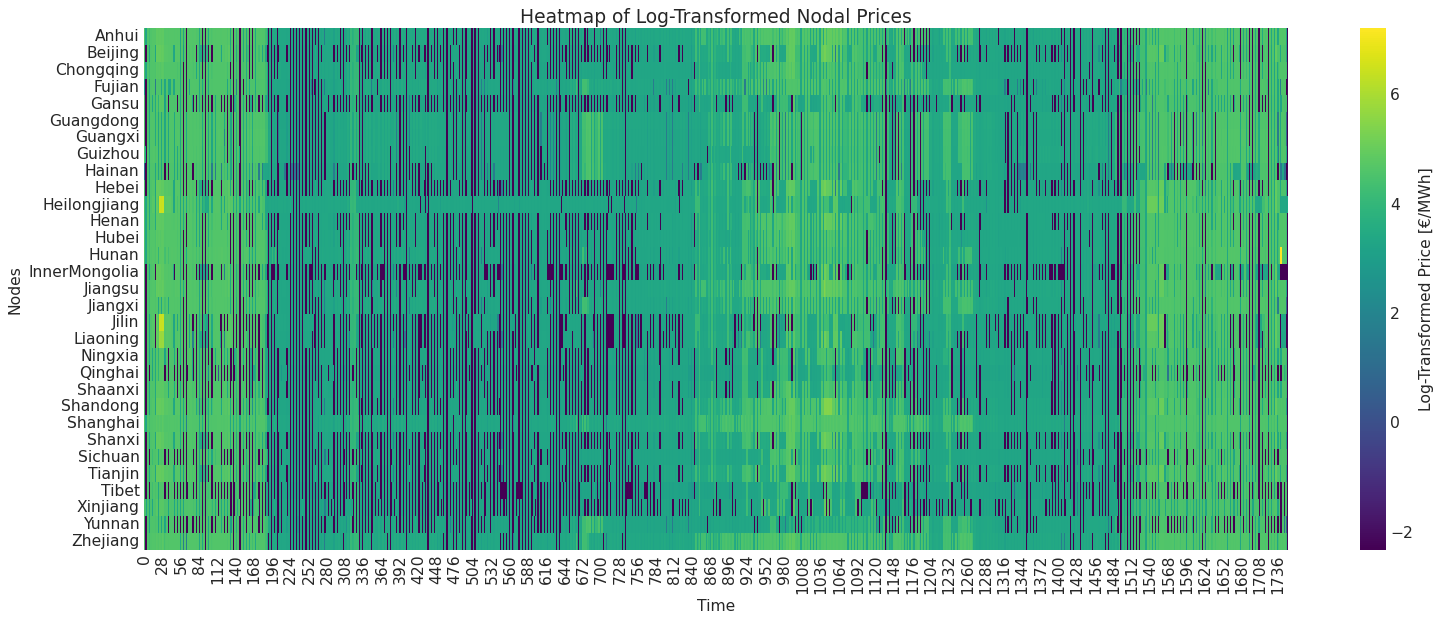

In [51]:
plot_price_heatmap(n, "AC", log_values=True)

<Axes: title={'center': 'Price Duration Curve'}>

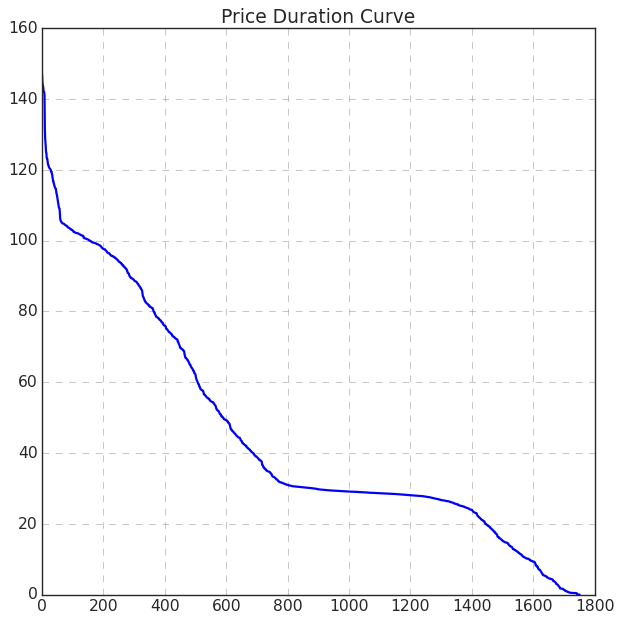

In [70]:
plot_price_duration_curve(n, carrier="AC")

<Axes: >

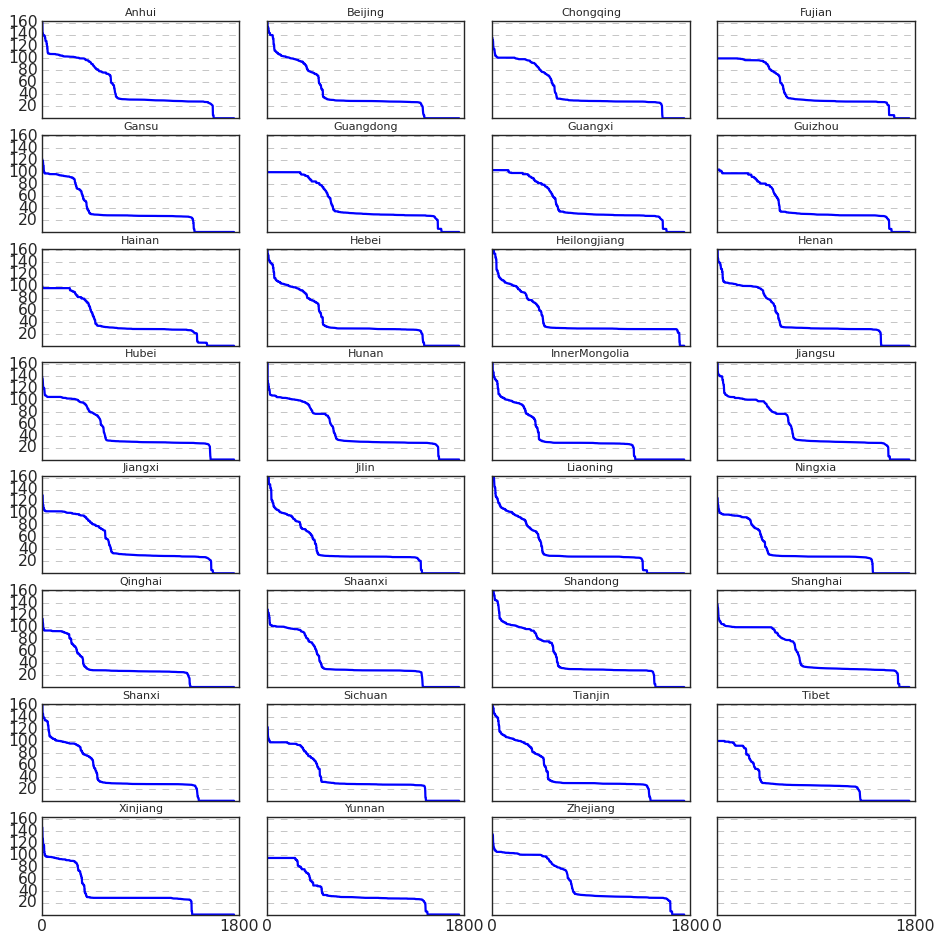

In [71]:
plot_price_duration_by_node(n, carrier="AC", logy=False)

<Axes: >

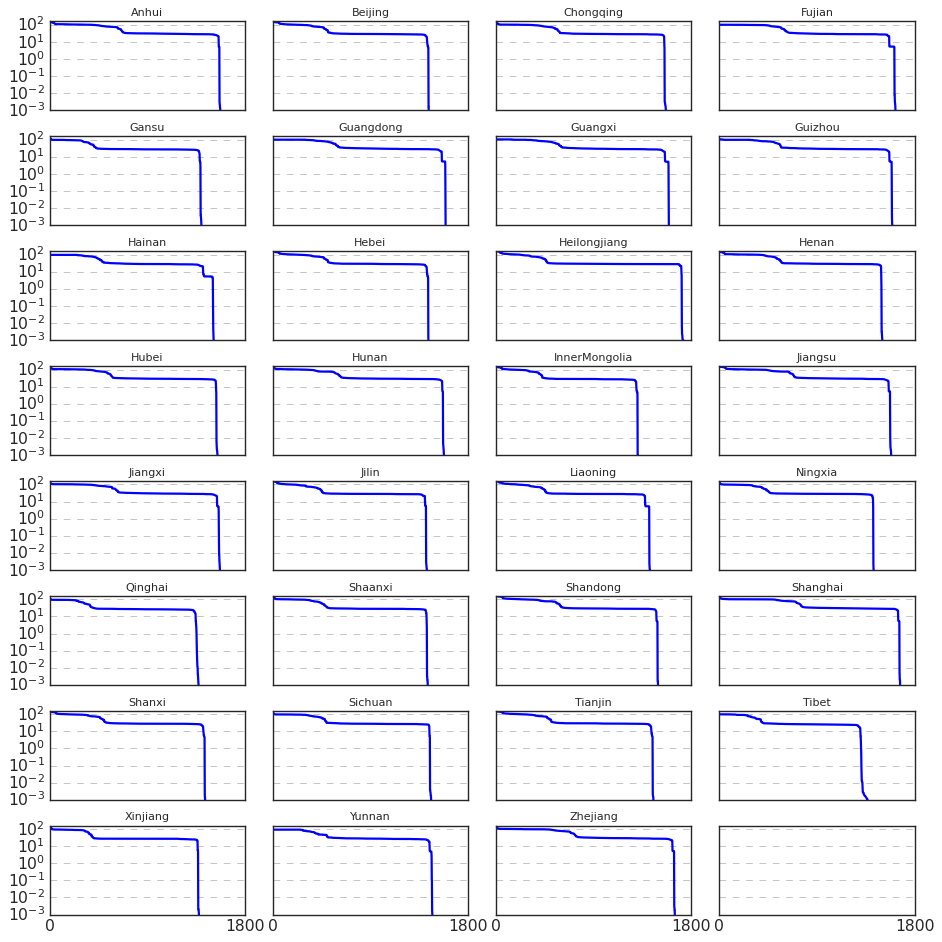

In [ ]:
plot_price_duration_by_node(n, carrier="AC")

<Axes: >

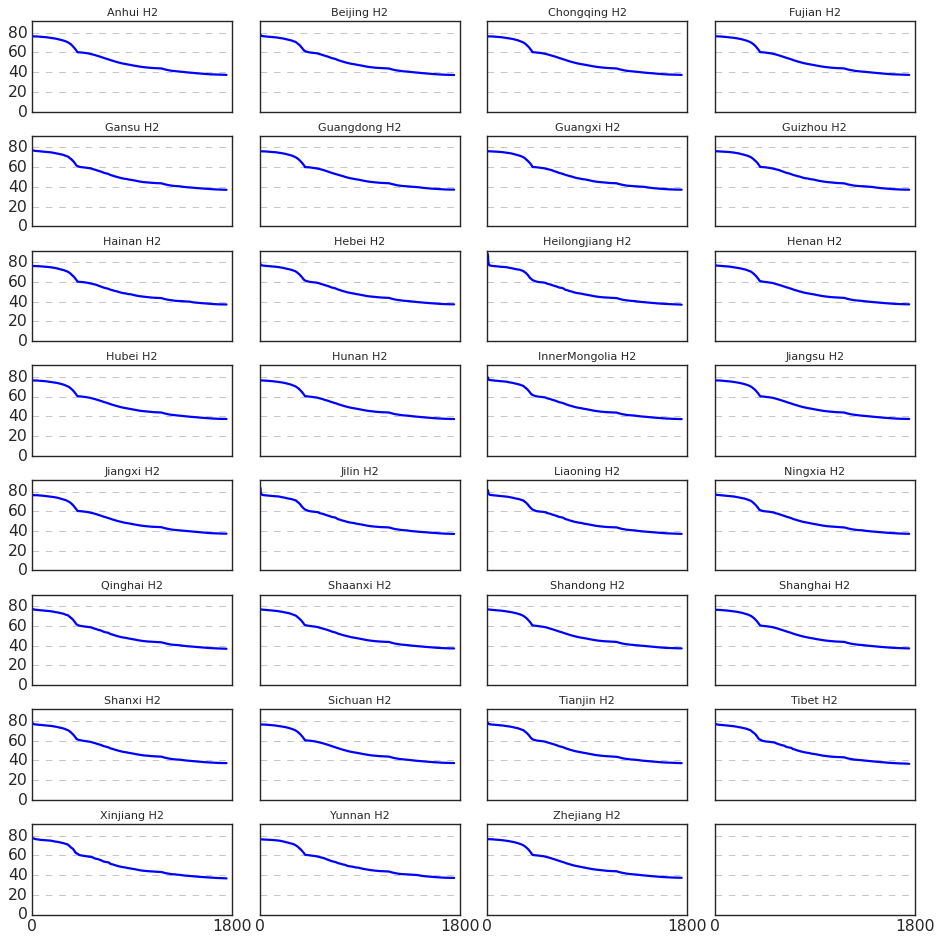

In [55]:
plot_load_duration_by_node(n, carrier="H2", logy=False, fig_shape=(8, 4), y_lower=0)

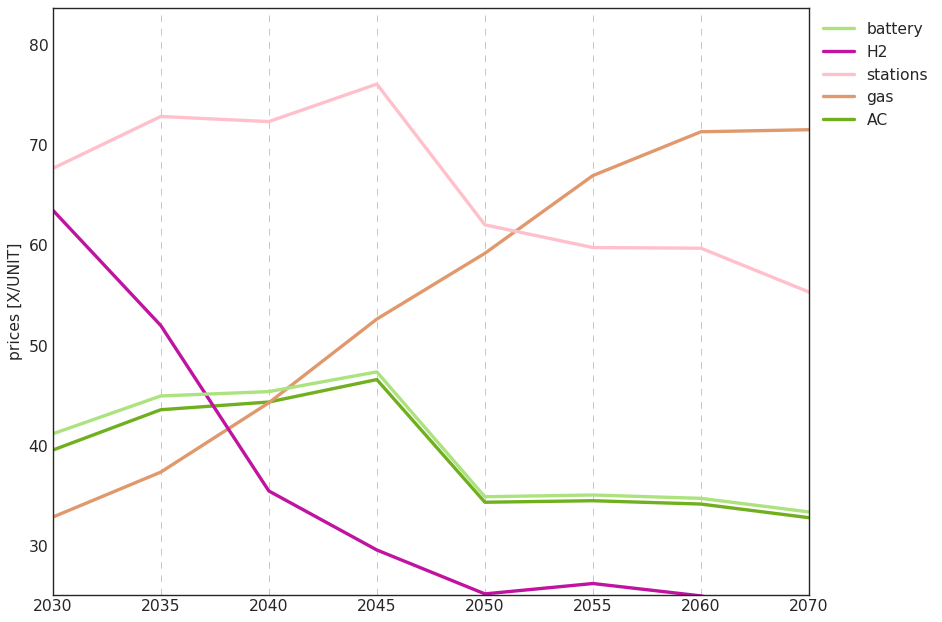

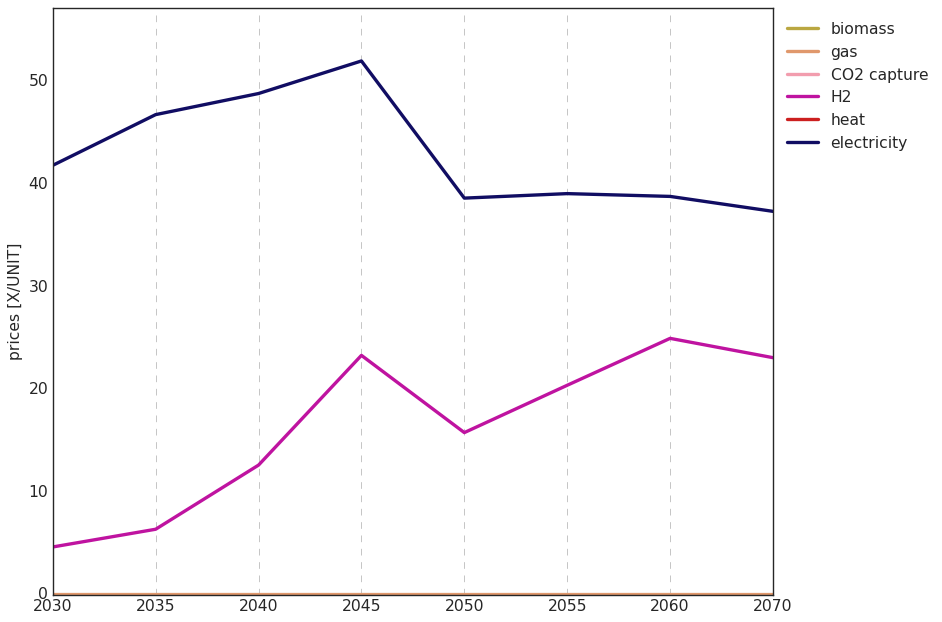

In [56]:
from plot_summary_all import plot_prices
paths = [os.path.join(results_dir, "summary", f"ntwk_{yr}") for yr in snakemake.config["scenario"]["planning_horizons"]]
data_paths = {
        "energy": [os.path.join(p, "energy.csv") for p in paths],
        "costs": [os.path.join(p, "costs.csv") for p in paths],
        "co2_price": [os.path.join(p, "metrics.csv") for p in paths],
        "time_averaged_prices": [os.path.join(p, "time_averaged_prices.csv") for p in paths],
        "weighted_prices": [os.path.join(p, "weighted_prices.csv") for p in paths],
        "co2_balance": [os.path.join(p, "co2_balance.csv") for p in paths],
        "energy_supply": [os.path.join(p, "supply_energy.csv") for p in paths],
        "capacity": [os.path.join(p, "capacities.csv") for p in paths],
    }

fig, ax = plt.subplots()
plot_prices(
    data_paths["time_averaged_prices"],
    config["plotting"],
    fig_name=None,
    ax=ax
)

fig, ax = plt.subplots()
plot_prices(
    data_paths["weighted_prices"],
    config["plotting"],
    fig_name=None,
    ax=ax,
)
# ax.semilogy()

In [57]:
stores_inflow = n.stores_t.p.sum()
h2_stores= stores_inflow.loc[[c for c in stores_inflow.index if c.find("H2 Store")!=-1]]
h2_stores_inflow = h2_stores.where(h2_stores>0,0).sum()
h2_stores_outflow = h2_stores.where(h2_stores<0,0).sum()

# STATS

In [59]:
def get_solver_tolerance(config: dict, tol_name = "BarConvTol")->float:
    """get the solver tolerance from the config 

    Args:
        config (dict): the config
        tol_name (str): the name of the tolerance option. Defaults to "BarConvTol"

    Returns:
        float: the value
    """    
    solver_opts = config["solving"]["solver"]["options"]
    return config["solving"]["solver_options"][solver_opts][tol_name]

def find_numerical_zeros(n, config, tolerance_name = "BarConvTol")->list:
    """
    Identify numerical zeros in the network's optimization results.

    This function checks for numerical zeros in the network's optimization results, 
    such as link capacities or weighted prices, based on a specified solver tolerance.

    Args:
        n (pypsa.Network): The PyPSA network object containing optimization results.
        config (dict): Configuration dictionary containing solver options.
        tolerance_name (str): The name of the solver tolerance option to use. Defaults to "BarConvTol".

    Returns:
        list: A list of items (e.g., links or buses) where numerical zeros are detected.
    """
 
    tol = get_solver_tolerance(config, tolerance_name)
    threshold = n.objective*float(tol)
    
    costs = pd.concat([n.statistics.expanded_capex(), n.statistics.opex()],axis=1)
    return costs.fillna(0).sum(axis=1).loc[costs.sum(axis=1) < threshold].index
    
num_zeros = find_numerical_zeros(n, config, tolerance_name = "BarConvTol")

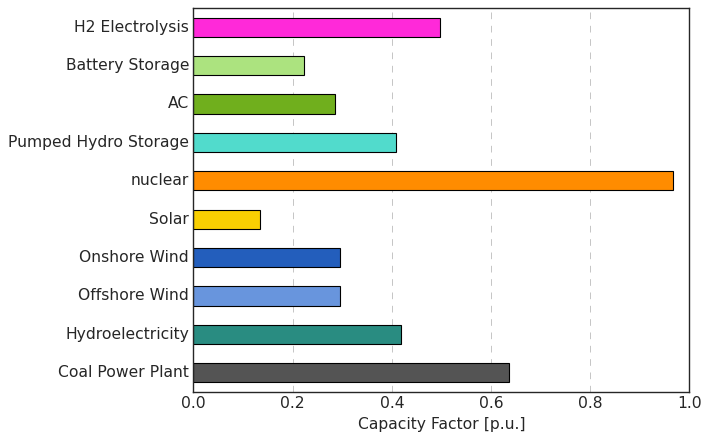

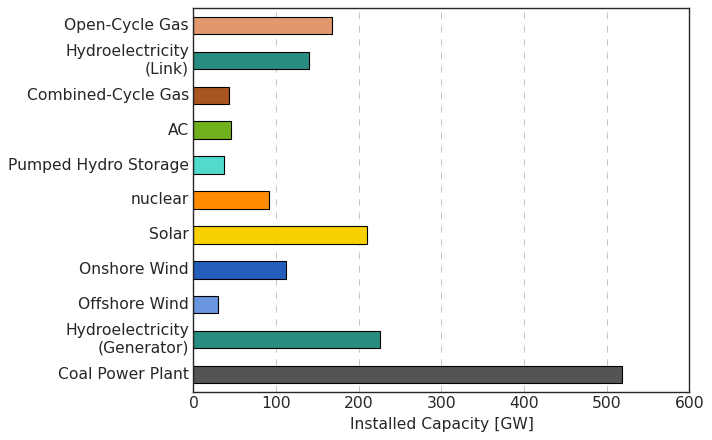

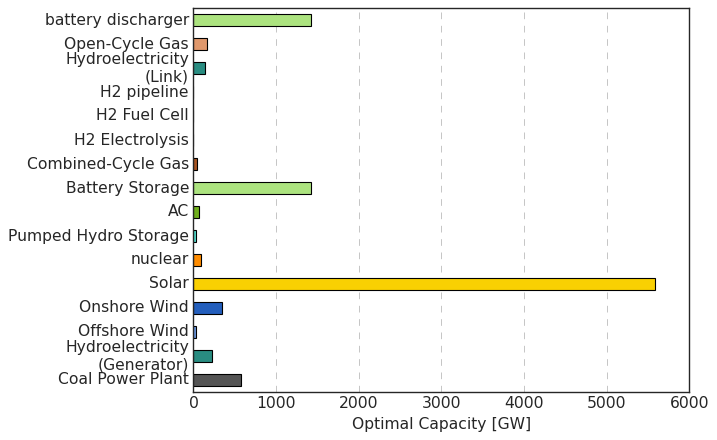

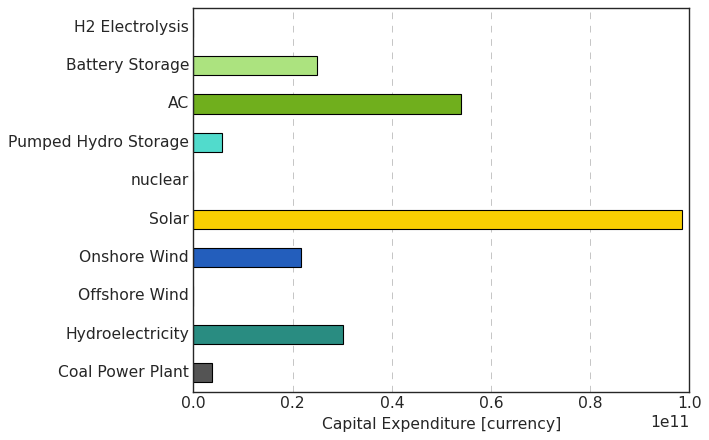

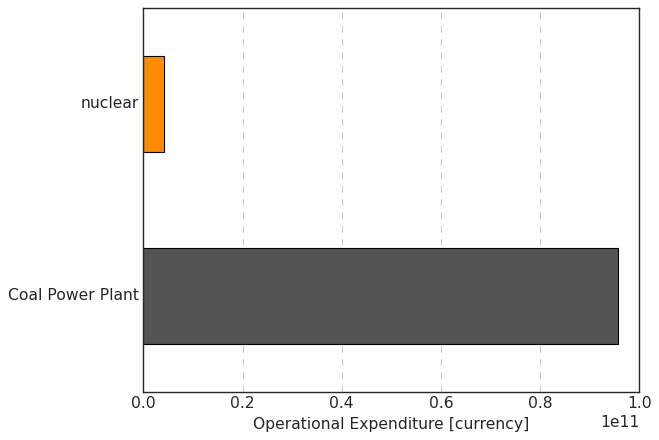

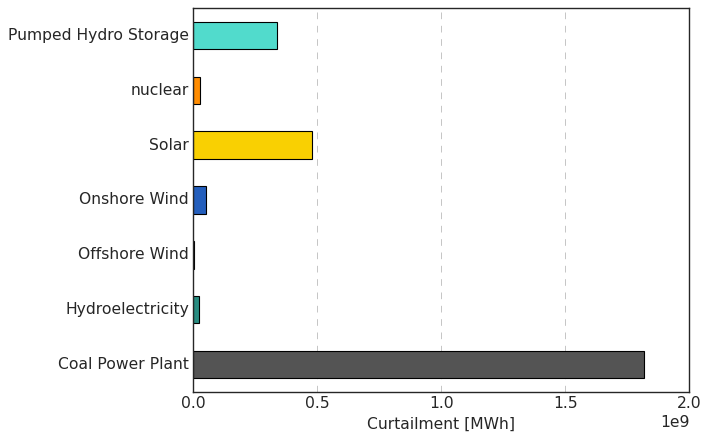

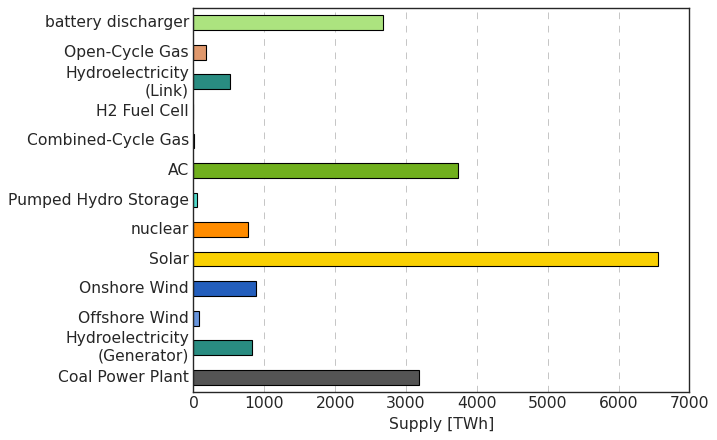

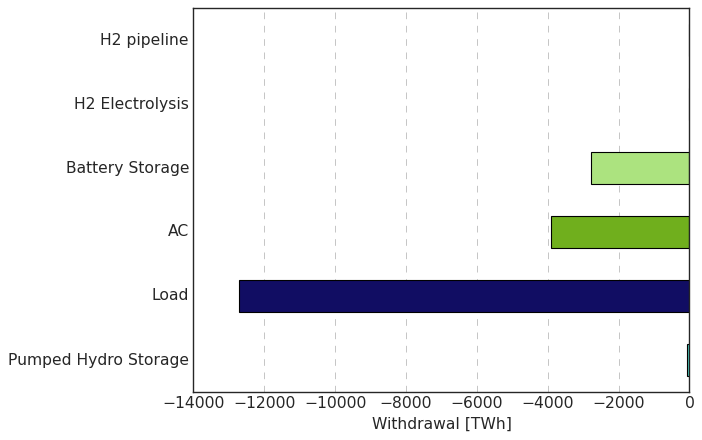

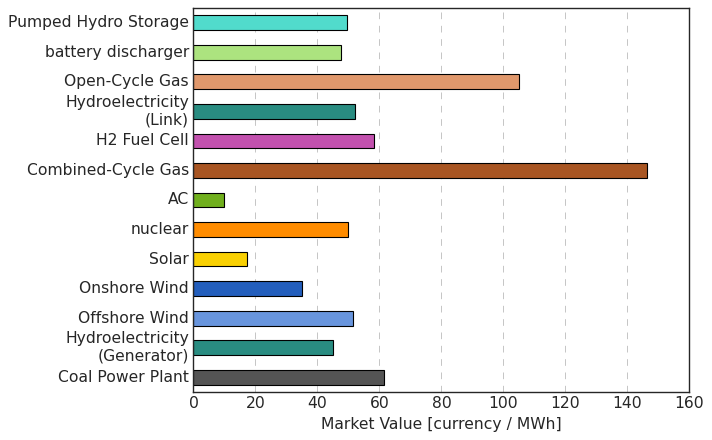

In [60]:
bus_carrier = "AC"
n.loads.carrier = "load"
n.carriers.loc["load", ["nice_name", "color"]] = "Load", "#110d63"
colors = n.carriers.set_index("nice_name").color.where(
    lambda s: s != "", "lightgrey"
)

def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)

def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")

fig, ax = plt.subplots()
ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds.abs(), ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds.abs() / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.capex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.opex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.curtailment(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.supply(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / 1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

if snakemake.config["heat_coupling"]:
    fig, ax = plt.subplots()
    ds = n.statistics.supply(bus_carrier="heat")
    if "Line" in ds.index:
        ds = ds.drop("Line")
    ds = ds / 1e6
    ds.attrs["unit"] = "TWh"
    plot_static_per_carrier(ds, ax)
    plt.show()

fig, ax = plt.subplots()
ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / -1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.market_value(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

In [61]:
def calc_lcoe(n: pypsa.Network, grouper = pypsa.statistics.get_carrier_and_bus_carrier, **kwargs)->pd.DataFrame:
    """calculate the LCOE for the network: (capex+opex)/supply.

    Args:
        n (pypsa.Network): the network for which LCOE is to be calaculated
        grouper (function | list, optional): function to group the data in network.statistics.
                Overwritten if groupby is passed in kwargs.
                Defaults to pypsa.statistics.get_carrier_and_bus_carrier. 
        **kwargs: other arguments to be passed to network.statistics
    Returns:
        pd.DataFrame: The LCOE for the network  with or without brownfield CAPEX. MV and delta

    """    
    if "groupby" in kwargs:
        grouper = kwargs.pop("groupby")

    rev= n.statistics.revenue(groupby=grouper,**kwargs)
    opex = n.statistics.opex(groupby=grouper,**kwargs)
    capex = n.statistics.expanded_capex(groupby=grouper,**kwargs)
    tot_capex = n.statistics.capex(groupby=grouper,**kwargs)
    supply = n.statistics.supply(groupby=grouper,**kwargs)

    profits = pd.concat([opex, capex, tot_capex, rev, supply], axis=1,  keys = ["OPEX", "CAPEX", "CAPEX_wBROWN", "Revenue", "supply"]).fillna(0)
    profits["rev-costs"]=profits.apply(lambda row: row.Revenue-row.CAPEX-row.OPEX, axis=1)
    profits["LCOE"] = profits.apply(lambda row: (row.CAPEX+row.OPEX)/row.supply, axis=1)
    profits["LCOE_wbrownfield"] = profits.apply(lambda row: (row.CAPEX_wBROWN+row.OPEX)/row.supply, axis=1)
    profits["MV"] = profits.apply(lambda row: row.Revenue/row.supply, axis=1)
    profits["profit_pu"]=profits["rev-costs"]/profits.supply
    profits.sort_values("profit_pu", ascending=False, inplace=True)
    
    return profits[profits.supply>0]




In [ ]:
rev_costs = calc_lcoe(n, groupby=None)


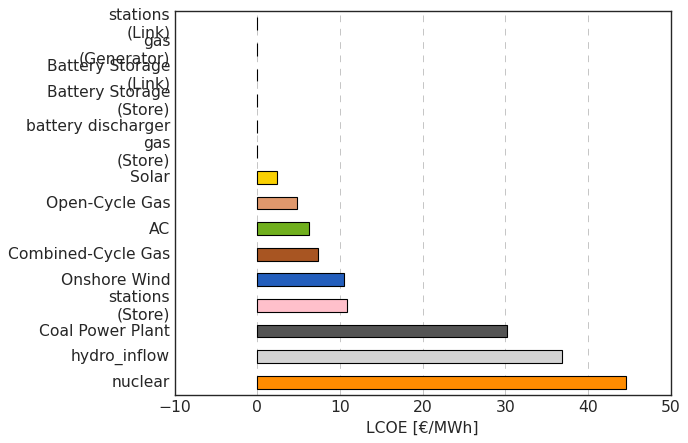

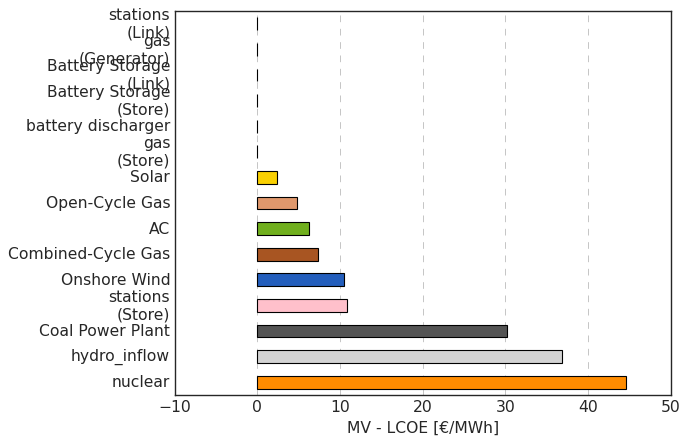

In [96]:
with io.capture_output() as captured:
    s = rev_costs["LCOE"]
    ds.attrs={"name":"LCOE", "unit":"€/MWh"}
    fig, ax = plt.subplots()
    plot_static_per_carrier(ds[~ds.index.isin(num_zeros)], ax)

    ds = rev_costs["profit_pu"]
    ds.attrs={"name":"MV - LCOE", "unit":"€/MWh"}
    fig, ax = plt.subplots()
    plot_static_per_carrier(ds[~ds.index.isin(num_zeros)], ax)


# Network topology
irrelevant as don't have lines

In [63]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in n.sub_networks.obj
]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]


# CO2 costs

In [64]:
if "emission_prices" in n.meta:
    em_price_gas = float(n.statistics.supply(comps="Generator")["gas"]*n.meta["emission_prices"]["co2"]*0.2/0.43)
    print(f"{em_price_gas:.2e}")
n.global_constraints

1.15e+10


Empty DataFrame
Columns: [type, investment_period, carrier_attribute, sense, constant, mu]
Index: []

In [ ]:
costs_s = costs_.T.sum()
dt = 5
costs_s.index = costs_s.index.astype(int)
co2_costs = co2.set_index("Year")["costs bnE"]
costs_df = pd.DataFrame({'Costs pw bn eur': costs_s, 'CO2 Costs bn eur': co2_costs})
costs_df["Costs no co2 bn eur"] = costs_df["Costs pw bn eur"] - costs_df["CO2 Costs bn eur"]
costs_df["discount"]=costs_df.apply(lambda x: 1.02**(x.name-min(costs_df.index)), axis =1)
discounted_costs = costs_df.apply(lambda x: x/x.discount, axis=1)
discounted_costs, costs_df.apply(lambda x: x.sum()*5 ), discounted_costs.apply(lambda x: x.sum()*5 )

(      Costs pw bn eur  CO2 Costs bn eur  Costs no co2 bn eur  discount
 2020       426.415207         54.897743           371.517464       1.0
 2025       459.913593         72.058113           387.855480       1.0
 2030       450.013123         55.538548           394.474575       1.0
 2035       428.357785         35.076815           393.280970       1.0
 2040       397.500409         19.424611           378.075799       1.0
 2045       375.332390         13.015016           362.317373       1.0
 2050       353.459437          8.496730           344.962707       1.0
 2055       368.593595         18.899338           349.694256       1.0
 2060       369.697213          0.000000           369.697213       1.0,
 Costs pw bn eur        27297.031714
 CO2 Costs bn eur        1763.846907
 Costs no co2 bn eur    25533.184807
 discount                  69.073939
 dtype: float64,
 Costs pw bn eur        18146.413756
 CO2 Costs bn eur        1387.034575
 Costs no co2 bn eur    16759.379181
 di

In [ ]:

ax = costs_.T.unstack(level=0).T.sort_index().plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    width=0.8, 
    legend=True)


# Customize the legend with a dictionary, including bbox_to_anchor
legend_kw = {
    'title': 'Carrier',          # Title of the legend
    'loc': 'upper left',              # Legend location (usually 'upper left' or 'best')
    'fontsize': 'small',              # Font size for the legend
    'frameon': False,                 # Remove the legend's frame
    'ncol': 2,                        # Number of columns in the legend
    'bbox_to_anchor': (1.05, 1),      # Adjust the legend's position (x, y)
    'borderaxespad': 0.5              # Padding between the legend and plot
}

# Apply the legend customization
ax.legend(**legend_kw)

# Validation

In [ ]:
import seaborn as sns

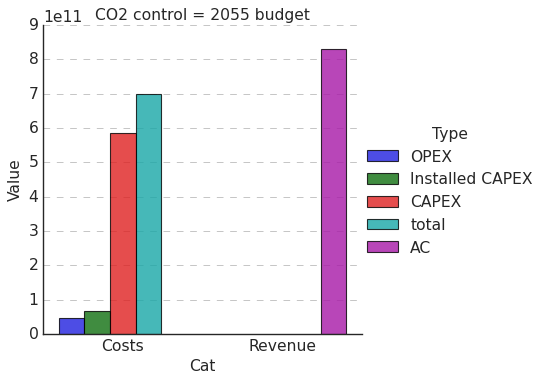

In [ ]:
capex_ = n.statistics.expanded_capex().sum()
installed_capex_ = n.statistics.installed_capex().sum()
opex_ = n.statistics.opex().sum()
costs_ = pd.DataFrame(
    {
        "OPEX": opex_,
        "Installed CAPEX": installed_capex_,
        "CAPEX": capex_,
        "total": capex_ + installed_capex_ + opex_,
    }, index = ["Costs"]
).stack()
revenue_ = n.statistics.revenue(comps="Load", bus_carrier="AC").sum()
costs_.loc[("Revenue", "AC")]=revenue_*-1
all_ = pd.concat({f"{PLANNING_YEAR} budget":costs_}, names=["CO2 control"])
all_.index.names = ["CO2 control", "Cat", "Type"]
all_ = pd.DataFrame(all_, columns = ["Value"])


sns.catplot(all_,x="Cat", y="Value",  hue="Type", col = "CO2 control", dodge=True, kind="bar", alpha =0.8)


In [ ]:
rev= n.statistics.revenue(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
opex = n.statistics.opex(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
capex = n.statistics.expanded_capex(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
supply = n.statistics.supply(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
index = rev.index.union(opex.index).union(capex.index)
rents = pd.concat([opex, capex, rev, supply], axis=1,  keys = ["OPEX", "CAPEX", "Revenue", "supply"]).fillna(0)
rents["delta"]=rents.apply(lambda row: row.Revenue-row.CAPEX-row.OPEX, axis=1)
rents["delta_pu"]=rents.delta/rents.supply
rents.sort_values("delta_pu", ascending=False, inplace=True)


In [ ]:
rents[rents.supply>1e5].droplevel(0).sort_values("delta_pu", ascending=False).plot.bar( y="delta_pu", stacked=True, figsize=(10, 6), ylabel="Rev-Costs Eur/MWh");

<Axes: xlabel='carrier,bus_carrier', ylabel='Rev-Costs Eur/MWh'>

# EXAMPLES